In [30]:
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import ray
from ray.rllib.agents import ppo, a3c, dqn, sac

from mdps.whited import cMDPWhited
from utils.distributions import ConstantDistribution, ParticleDistribution, UniformDistribution

In [31]:
# collect expert rollout

def get_rollouts(solver_, config):
    """Generate rollouts from a given solver and MDP(c)"""
    env_ = cMDPWhited(config=config)
    done_ = False
    obs_ = env_.reset()
    # run until episode ends
    gt_obs_arr_ = obs_
    gt_act_arr_ = None
    gt_rew_arr_ = None
    while not done_:
        action_ = solver_.compute_single_action(obs_)
        obs_, rewawrd_, done_, _ = env_.step(action_)
        gt_obs_arr_ = np.vstack((gt_obs_arr_, obs_))
        if gt_act_arr_ is None:
            gt_act_arr_ = [action_]
            gt_rew_arr_ = [rewawrd_]
        else:
            gt_act_arr_ += [action_]
            gt_rew_arr_ += [rewawrd_]

    gt_act_arr_ = np.array(gt_act_arr_)
    gt_rew_arr_ = np.array(gt_rew_arr_)
    return gt_obs_arr_[1:,:], gt_act_arr_, gt_rew_arr_

def plot_rollouts(gt_obs_arr_, gt_act_arr_):
    """Plot generated rollouts"""
    fig_, ax_1 = plt.subplots()
    fig_.set_size_inches(10, 6, forward=True)

    x = np.arange(start=0, stop=gt_obs_arr_.shape[0])
    ax_2 = ax_1.twinx()
    ax_1.plot(x, gt_obs_arr_[:,0], 'r-')
    ax_2.plot(x, gt_act_arr_, 'b-', alpha=0.3)

    ax_1.set_xlabel('time step')
    ax_1.set_ylabel('Capital(k)', color='r')
    ax_2.set_ylabel('Action', color='b')
    plt.title('sample observations and actions')
    plt.show()

    fig_, ax_3 = plt.subplots()
    fig_.set_size_inches(10, 6, forward=True)

    x = np.arange(start=0, stop=gt_obs_arr_.shape[0])
    ax_4 = ax_3.twinx()
    ax_3.plot(x, gt_obs_arr_[:,1], 'r-')
    ax_4.plot(x, gt_act_arr_, 'b-', alpha=0.3)

    ax_3.set_xlabel('time step')
    ax_3.set_ylabel('Shock(z)', color='r')
    ax_4.set_ylabel('Action', color='b')
    plt.title('sample observations and actions')
    plt.show()

In [39]:
'''
c = {"context_distribution":
        ConstantDistribution(dim=5, constant_vector=np.array([0.98, 0.15, 0.7, 0.7, 0.15])),
     "psi_fn": 
        lambda i, k: 0.01*i**2/(2*k)
    }
'''
c = {"context_distribution":
        ConstantDistribution(dim=5, constant_vector=np.array([0.98, 0.15, 0.7, 0.7, 0.15]))
    }

### 1. ppo

In [54]:
ray.shutdown()
ray.init()

expert = ppo.PPOTrainer(env=cMDPWhited, config={
    "env_config": c,
    "framework": "torch",  # config to pass to env class
})

rews = []
for eps in range(35):
    res = expert.train()
    if eps % 5 == 0:
        print(eps, res['episode_reward_mean'])
    rews += [res['episode_reward_mean']]

2022-03-15 23:11:47,374	WARNING util.py:57 -- Install gputil for GPU system monitoring.
2022-03-15 23:11:56,862	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 2698109354193.0x the scale of `vf_clip_param`. This means that it will take more than 2698109354193.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.


0 -26981093541931.11


2022-03-15 23:12:06,208	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 1403266879298.0x the scale of `vf_clip_param`. This means that it will take more than 1403266879298.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-15 23:12:15,353	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 943816262059.0x the scale of `vf_clip_param`. This means that it will take more than 943816262059.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-15 23:12:24,575	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 33348027207.0x the scale of `vf_clip_param`. This means that it will take more than 33348027207.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-15 23:12:33,703	WARNING ppo.py:245 -- The magnitude of y

5 -335590533.13576716


2022-03-15 23:12:51,937	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 2771072.0x the scale of `vf_clip_param`. This means that it will take more than 2771072.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-15 23:13:01,108	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 274391.0x the scale of `vf_clip_param`. This means that it will take more than 274391.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-15 23:13:10,169	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 17628.0x the scale of `vf_clip_param`. This means that it will take more than 17628.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-15 23:13:19,268	WARNING ppo.py:245 -- The magnitude of your environment rewards are more tha

10 -20299.040547579094


2022-03-15 23:13:37,553	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 234.0x the scale of `vf_clip_param`. This means that it will take more than 234.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.


15 711.2105412153765
20 782.9871066904914
25 844.4173477102091
30 853.0941059568763


### 2. a3c

In [41]:
ray.shutdown()
ray.init()

expert_a3c = a3c.A3CTrainer(env=cMDPWhited, config={
    "env_config": c,
    "framework": "torch",  # config to pass to env class
})

rews = []
for eps in range(35):
    res = expert_a3c.train()
    if eps % 5 == 0:
        print(eps, res['episode_reward_mean'])
    rews += [res['episode_reward_mean']]

 pid=15260) 2022-03-15 23:03:25,712	WARNING deprecation.py:45 -- DeprecationWarning: `convert_to_non_torch_type` has been deprecated. Use `ray/rllib/utils/numpy.py::convert_to_numpy` instead. This will raise an error in the future!
2022-03-15 23:03:25,728	WARNING deprecation.py:45 -- DeprecationWarning: `convert_to_non_torch_type` has been deprecated. Use `ray/rllib/utils/numpy.py::convert_to_numpy` instead. This will raise an error in the future!
2022-03-15 23:03:25,737	WARNING util.py:57 -- Install gputil for GPU system monitoring.


0 nan
5 18.235315652755272
10 225.7319698404021
15 319.68934038207846
20 305.5817401958143
25 445.72527608981983
30 338.1154877348745


### 3. dqn

In [42]:
ray.shutdown()
ray.init()

expert_dqn = dqn.DQNTrainer(env=cMDPWhited, config={
    "env_config": c,
    "framework": "torch",  # config to pass to env class
})

rews = []
for eps in range(35):
    res = expert_dqn.train()
    if eps % 5 == 0:
        print(eps, res['episode_reward_mean'])
    rews += [res['episode_reward_mean']]

2022-03-15 23:06:29,517	WARNING util.py:57 -- Install gputil for GPU system monitoring.


0 -35021978501316.457
5 -195660264366366.66
10 -115547918846977.69
15 -2494287877004.164


(pid=None) [2022-03-15 23:07:30,307 C 70756 65236] gcs_client.cc:328: Couldn't reconnect to GCS server. The last attempted GCS server address was :0
(pid=None) *** StackTrace Information ***
(pid=None)     BaseThreadInitThunk
(pid=None)     RtlUserThreadStart
(pid=None) 


20 -840329799691.7295
25 -2.546290894492412e+18
30 -4.2896413629726367e+18


### 4. sac

In [43]:
ray.shutdown()
ray.init()

expert_sac = sac.SACTrainer(env=cMDPWhited, config={
    "env_config": c,
    "framework": "torch",  # config to pass to env class
})

rews = []
for eps in range(35):
    res = expert_sac.train()
    if eps % 5 == 0:
        print(eps, res['episode_reward_mean'])
    rews += [res['episode_reward_mean']]

2022-03-15 23:08:50,660	WARNING util.py:57 -- Install gputil for GPU system monitoring.


0 -1.1742521981692072e+19
5 -8.806891486269055e+18
10 -7.045513189015244e+18
15 -5.871260990846037e+18
20 -5.032509420725174e+18
25 -4.4034457431345464e+18
30 -3.9141739938973747e+18


In [148]:
gt_obs_arr, gt_act_arr, gt_rew_arr = get_rollouts(expert_sac, config=c)

In [156]:
r = np.zeros(500)
for i in range(500):
    gt_obs_arr, gt_act_arr, gt_rew_arr = get_rollouts(expert_sac, config=c)
    r[i] = sum(gt_rew_arr)
print(np.mean(r))

748.3322853572136


2022-03-16 19:03:00,819	WARNING worker.py:1245 -- The node with node id: c38fd91f6e5e6ed9eb88435682ce4a773c9e3e4fe305fbfb59fedda5 and ip: 127.0.0.1 has been marked dead because the detector has missed too many heartbeats from it. This can happen when a raylet crashes unexpectedly or has lagging heartbeats.
(pid=None) [2022-03-16 19:03:00,825 C 69188 52628] node_manager.cc:809: [Timeout] Exiting because this node manager has mistakenly been marked as dead by the GCS: GCS didn't receive heartbeats from this node for 30000 ms. This is likely because the machine or raylet has become overloaded.
(pid=None) *** StackTrace Information ***
(pid=None)     BaseThreadInitThunk
(pid=None)     RtlUserThreadStart
(pid=None) 


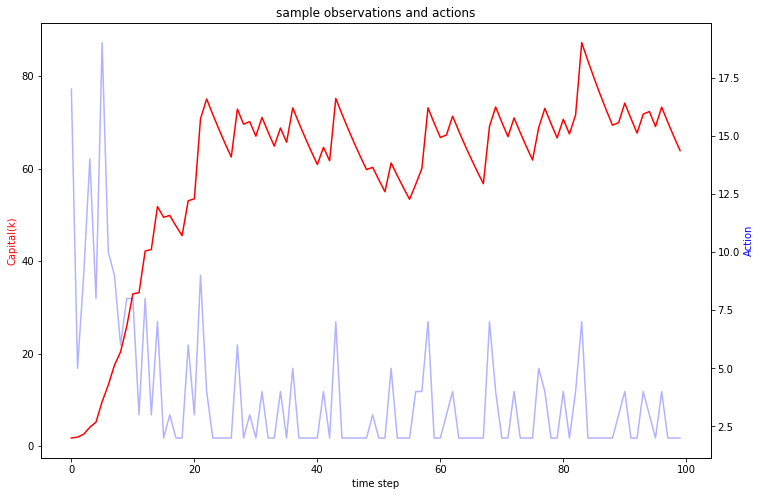

In [151]:
fig_, ax_1 = plt.subplots()
fig_.set_size_inches(12, 8, forward=True)

x = np.arange(start=0, stop=gt_obs_arr.shape[0])
ax_2 = ax_1.twinx()
ax_1.plot(x, gt_obs_arr[:,0], 'r-')
ax_2.plot(x, gt_act_arr, 'b-', alpha=0.3)

ax_1.set_xlabel('time step')
ax_1.set_ylabel('Capital(k)', color='r')
ax_2.set_ylabel('Action', color='b')
plt.title('sample observations and actions')
# plt.savefig('basic_sac.pdf')
plt.show()

---

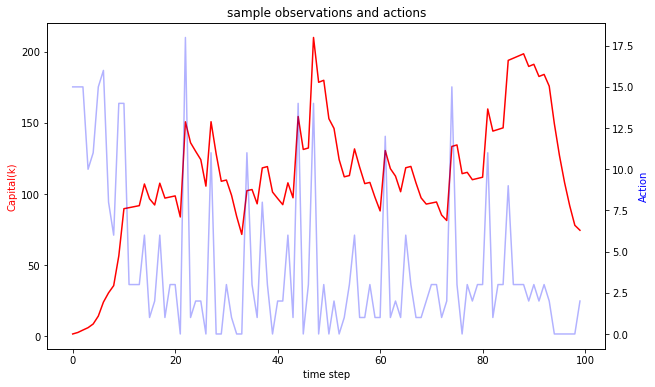

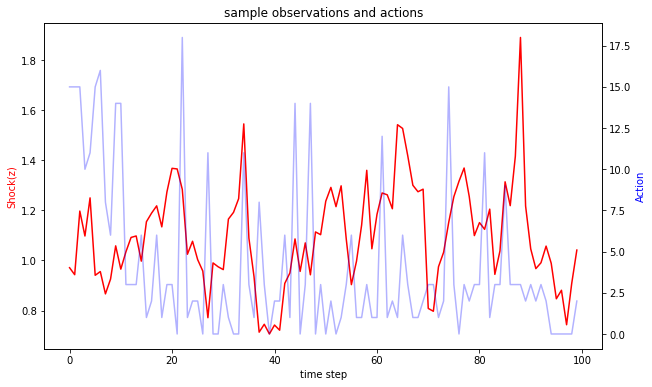

In [38]:
'''
c_sim = {"context_distribution":
        ConstantDistribution(dim=5, constant_vector=np.array([0.98, 0.15, 0.7, 0.7, 0.15])),
     "env_config":
         {"psi_fn": 
            lambda i, k: 0.01*i**2/(2*k)
         }
    }
'''

c_sim = {"context_distribution":
        ConstantDistribution(dim=5, constant_vector=np.array([0.98, 0.15, 0.7, 0.7, 0.15]))
         }

gt_obs_arr, gt_act_arr, gt_rew_arr = get_rollouts(expert, config=c_sim)
plot_rollouts(gt_obs_arr, gt_act_arr)


In [15]:
np.save("gtobs_whited.npy", gt_obs_arr)
np.save("gtact_whited.npy", gt_act_arr)
np.save("gtrew_whited.npy", gt_rew_arr)

In [4]:
gt_act_arr = np.load("gtact_whited.npy")
gt_obs_arr = np.load("gtobs_whited.npy")
gt_rew_arr = np.load("gtrew_whited.npy")

In [5]:
N = 1000000
T = 100

def posterior_sample_params(action=gt_act_arr, reward=gt_rew_arr, N=N, obs=gt_obs_arr,):
    theta_sample = np.random.normal(loc=1.,scale=1.,size=N)
    rho_sample = np.random.normal(loc=1.,scale=1.,size=N)
    sigma_sample = np.random.normal(loc=0.5,scale=1.,size=N)
    k = obs[:,0]
    z = obs[:,1]
    I = action.reshape(-1)*k/19
    r = reward.reshape(-1)

    for t in range(T-1):
        # evaluate probability of particles
        z_t = (r[t]+I[t])/k[t]**theta_sample

        eps_reward = np.log(z[t+1])-rho_sample*np.log(z_t)
        q_reward = stats.norm.pdf(eps_reward, loc=0, scale=sigma_sample)
        q_reward = np.nan_to_num(q_reward, copy=False)
        if q_reward.sum() == 0.0:
            continue

        eps = np.log(z[t+1])-rho_sample*np.log(z[t])
        q = stats.norm.pdf(eps, loc=0, scale=sigma_sample)
        q = np.nan_to_num(q, copy=False)
        # resample particles according to probability
        resample_index_reward = np.random.choice(np.arange(N), N, p=q_reward/q_reward.sum())
        theta_sample = theta_sample[resample_index_reward]
        
        resample_index = np.random.choice(np.arange(N), N, p=q/q.sum())
        rho_sample = rho_sample[resample_index]
        sigma_sample = sigma_sample[resample_index]
        if t % 25 == 0:
            print("round", t, "posterior mean", theta_sample.mean())

    return theta_sample, rho_sample, sigma_sample

In [6]:
theta_prior = np.random.normal(loc=1.,scale=1.,size=N)
rho_prior = np.random.normal(loc=1.,scale=1.,size=N)
sigma_prior = np.random.normal(loc=0.5,scale=1.,size=N)

theta_post, rho_post, sigma_post = posterior_sample_params()

round 0 posterior mean 0.84141189780671
round 25 posterior mean 0.7400642686319447
round 50 posterior mean 0.7392644955800487
round 75 posterior mean 0.7375059527182507


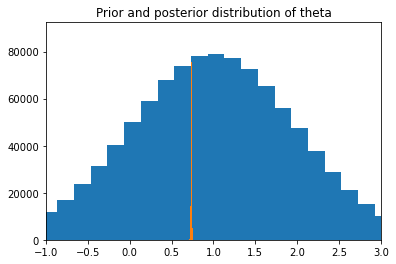

In [7]:
plt.hist(theta_prior, bins=50)
plt.hist(theta_post, bins=50)
plt.xlim((-1,3))
plt.title('Prior and posterior distribution of theta')
plt.show()

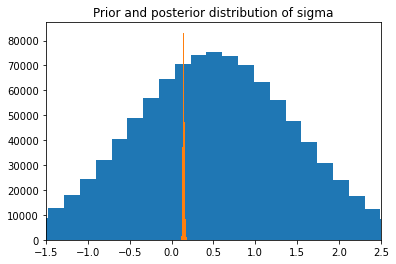

In [8]:
plt.hist(sigma_prior, bins=50)
plt.hist(sigma_post, bins=50)
plt.xlim((-1.5,2.5))
plt.title('Prior and posterior distribution of sigma')
plt.show()

In [10]:
print(theta_post.mean())
print(sigma_post.mean())

0.7355451037208641
0.14297032963257733


## 1. Estiamtion for $\theta$

In [6]:
# Filter function
def filter_context(solver_,
                   context_distribution_,
                   gt_obs_arr_,
                   T_,
                   N_
                   ):
    state_arr_ = np.ones((N_,2))
    action_arr_ = np.zeros((N_,))
    context_history_ = []
    for t_ in range(T_):
        # we only use the first 5 steps of the cartpole steps to reduce effect of different episode lengths
        qs_ = np.zeros((N_,))
        for n_ in range(N_):
            context_ = context_distribution_.particles[n_]
            c_local_ = {"context_distribution":
                           ConstantDistribution(dim=5,
                                                constant_vector=context_)
            }
            env_ = cMDPWhited(config=c_local_)
            obs_ = env_.reset()
            if t_ > 0:
                env_.mdp.state = state_arr_[n_]
                obs_ = np.concatenate((np.array(env_.mdp.state), context_), axis=0).flatten()
            action_ = solver_.compute_single_action(obs_)
            obs_, reward_, _, _ = env_.step(action_)
            # estimate likelihood if r >= 1
            action_arr_[n_] = action_
            q = env_.likelihood(gt_obs_arr_[t_], action_arr_[n_], obs_, reward_)
            qs_[n_] = q
            state_arr_[n_] = np.copy(env_.mdp.state)
        if t_ >= 1:
            # truncated importance sampling; [https://arxiv.org/pdf/1905.09800.pdf]
            qs_ = np.clip(qs_, 0, np.percentile(qs_, 90))
            if qs_.sum() == 0:
                continue
            qs_ = qs_ / qs_.sum()
            resample_index_ = context_distribution_.resample_particles_from_probability(p=qs_)
            p_temp_ = context_distribution_.particles
            p_noise_ = np.random.normal(loc=0, scale=p_temp_.std(axis=0), size=p_temp_.shape) * 0.05
            context_distribution_.particles += p_noise_
            context_distribution_.particles = np.clip(context_distribution_.particles, 0.0, 1.0)
            state_arr_ = state_arr_[resample_index_]
            action_arr_ = action_arr_[resample_index_]
        if t_ % 25 == 0:
            print("round", t_, "posterior mean", context_distribution_.particles[:, 2].mean())
        context_history_ += [context_distribution_.particles.copy()]
    return context_history_, context_distribution_

In [7]:
# Pre-determined params
N = 1000
T = 100

gamma = np.ones((N,)) * 0.98
delta = np.ones((N,)) * 0.15
theta = np.random.uniform(0.4, 0.8, size=(N,))
rho = np.ones((N,)) * 0.7
sigma = np.ones((N,)) * 0.15

context_particles = np.abs(np.vstack((gamma, delta, theta, rho, sigma)).T)
context_distribution = ParticleDistribution(dim=5, particles=context_particles, n_particles=N)

### a. Exact context

In [20]:
c = {"context_distribution":
        ConstantDistribution(dim=5, constant_vector=np.array([0.98, 0.15, 0.7, 0.7, 0.15]))
    }

ray.shutdown()
ray.init()

expert = ppo.PPOTrainer(env=cMDPWhited, config={
    "env_config": c,
    "framework": "torch",  # config to pass to env class
})

rews = []
for eps in range(35):
    res = expert.train()
    if eps % 5 == 0:
        print(eps, res['episode_reward_mean'])
    rews += [res['episode_reward_mean']]

2022-03-06 10:12:57,182	WARNING util.py:57 -- Install gputil for GPU system monitoring.
2022-03-06 10:13:06,526	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 975673441399.0x the scale of `vf_clip_param`. This means that it will take more than 975673441399.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.


0 -9756734413992.617


2022-03-06 10:13:15,005	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 500432646913.0x the scale of `vf_clip_param`. This means that it will take more than 500432646913.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-06 10:13:23,425	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 148601708090.0x the scale of `vf_clip_param`. This means that it will take more than 148601708090.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-06 10:13:31,802	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 6273277732.0x the scale of `vf_clip_param`. This means that it will take more than 6273277732.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-06 10:13:40,737	WARNING ppo.py:245 -- The magnitude of your 

5 -209798715.0903319


2022-03-06 10:13:58,751	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 5139242.0x the scale of `vf_clip_param`. This means that it will take more than 5139242.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-06 10:14:07,803	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 216180.0x the scale of `vf_clip_param`. This means that it will take more than 216180.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-06 10:14:16,803	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 78216.0x the scale of `vf_clip_param`. This means that it will take more than 78216.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-06 10:14:26,387	WARNING ppo.py:245 -- The magnitude of your environment rewards are more tha

10 -15225.290849604253


2022-03-06 10:14:44,349	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 413.0x the scale of `vf_clip_param`. This means that it will take more than 413.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.


15 613.8529960099868
20 715.4429647668101
25 789.0695184810982
30 861.0849256610101


In [325]:
def multi_round_context(sim_solver_,
                        sim_config_,
                        solver_,
                        context_particles_,
                        T_,
                        N_,
                        n_trajectory_,
                        n_round_,
                        which_param_
                        ):
    context_ = None
    context_mean_ = None
    for i_ in range(n_trajectory_):
        gt_obs_arr_, _, _ = get_rollouts(sim_solver_, config=sim_config_)
        for j_ in range(n_round_):
            context_distribution_ = ParticleDistribution(
                dim=5, particles=context_particles_, n_particles=N_)
            context_history_, _ = filter_context(solver_,
                                                 context_distribution_,
                                                 gt_obs_arr_,
                                                 T_,
                                                 N_
                                                 )
            context_curr_ = context_history_[-1][:, which_param_]
            if context_ is None:
                context_ = context_curr_
                context_mean_ = [context_curr_.mean()]
            else:
                context_ = np.concatenate((context_, context_curr_))
                context_mean_ += [context_curr_.mean()]
            print("round", (i_ + 1, j_ + 1))
    context_mean_ = np.array(context_mean_)

    return context_, context_mean_


In [326]:
c_sim = {"context_distribution":
        ConstantDistribution(dim=5, constant_vector=np.array([0.98, 0.15, 0.7, 0.7, 0.15]))
         }

context_exact_multi, context_mean_exact_multi = multi_round_context(expert,
                                                                c_sim,
                                                                expert,
                                                                context_particles,
                                                                T,
                                                                N,
                                                                4,
                                                                3,
                                                                2)

round 0 posterior mean 0.6009861863934334


c:\Users\ZhenghaoJiang\Documents\GitHub\cmdp\mdps\whited.py:124: RuntimeWarning: invalid value encountered in log
  eps = np.log(z_curr)-rho*np.log(z_prev)


round 25 posterior mean 0.7338231289282546
round 50 posterior mean 0.743110122877516
round 75 posterior mean 0.7342181628662195
round (1, 1)
round 0 posterior mean 0.6009861863934334
round 25 posterior mean 0.7461349006913542
round 50 posterior mean 0.7510216502878393
round 75 posterior mean 0.735577327719579
round (1, 2)
round 0 posterior mean 0.6009861863934334
round 25 posterior mean 0.71320124972354
round 50 posterior mean 0.7074036646397621
round 75 posterior mean 0.7143206166229398
round (1, 3)
round 0 posterior mean 0.6009861863934334
round 25 posterior mean 0.7433614519036992
round 50 posterior mean 0.7508759225402492
round 75 posterior mean 0.7557978087042837
round (2, 1)
round 0 posterior mean 0.6009861863934334
round 25 posterior mean 0.7624826532380705
round 50 posterior mean 0.7667656823833574
round 75 posterior mean 0.7580079656434721
round (2, 2)
round 0 posterior mean 0.6009861863934334
round 25 posterior mean 0.7442455687947398
round 50 posterior mean 0.755377633616069

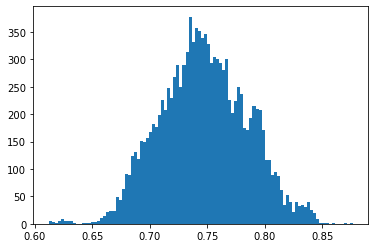

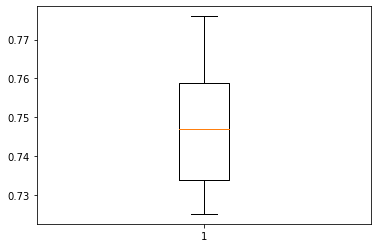

(pid=None) [2022-03-04 13:07:36,564 C 63480 70964] redis_client.cc:87:  Check failed: under_retry_limit Expected 1 Redis shard addresses, found 8104303535147543913
(pid=None) *** StackTrace Information ***
(pid=None)     recalloc
(pid=None)     BaseThreadInitThunk
(pid=None)     RtlUserThreadStart
(pid=None) 
(pid=None) [2022-03-04 13:07:42,677 E 53536 56240] local_object_manager.cc:32: Plasma object ffffffffffffffffffffffffffffffffffffffff0100000001000000 was evicted before the raylet could pin it.
(pid=None) [2022-03-04 13:07:42,685 C 53536 56240] local_object_manager.cc:88:  Check failed: (pinned_objects_.count(object_id) > 0) || (spilled_objects_url_.count(object_id) > 0) || (objects_pending_spill_.count(object_id) > 0) 
(pid=None) *** StackTrace Information ***
(pid=None)     BaseThreadInitThunk
(pid=None)     RtlUserThreadStart
(pid=None) 
2022-03-04 13:08:11,032	WARNING worker.py:1245 -- The node with node id: 2e0a7f7eb16dcada8385e635b86d624eb425424c14e7f4ceae5d4e16 and ip: 127.

In [327]:
plt.hist(context_exact_multi, bins=100)
plt.show()
plt.boxplot(context_mean_exact_multi)
plt.show()

In [253]:
# np.save("context_exact.npy", context_exact_multi)
# np.save("context_mean_exact.npy", context_mean_exact_multi)

In [8]:
# Estimation

N = 1000
T = 100

gamma = np.ones((N,)) * 0.98
delta = np.ones((N,)) * 0.15
theta = np.random.uniform(0.4, 0.8, size=(N,))
rho = np.ones((N,)) * 0.7
sigma = np.ones((N,)) * 0.15

context_particles = np.abs(np.vstack((gamma, delta, theta, rho, sigma)).T)
context_distribution = ParticleDistribution(dim=5, particles=context_particles, n_particles=N)

context_history_exact, _ = filter_context(expert,
                                          context_distribution,
                                          gt_obs_arr,
                                          T,
                                          N
                                          )

round 0 posterior mean 0.604700772532896


c:\Users\ZhenghaoJiang\Documents\GitHub\cmdp\mdps\whited.py:124: RuntimeWarning: invalid value encountered in log
  eps = np.log(z_curr)-rho*np.log(z_prev)


round 25 posterior mean 0.7607264633605015
round 50 posterior mean 0.7666086503818945
round 75 posterior mean 0.7628990444304609


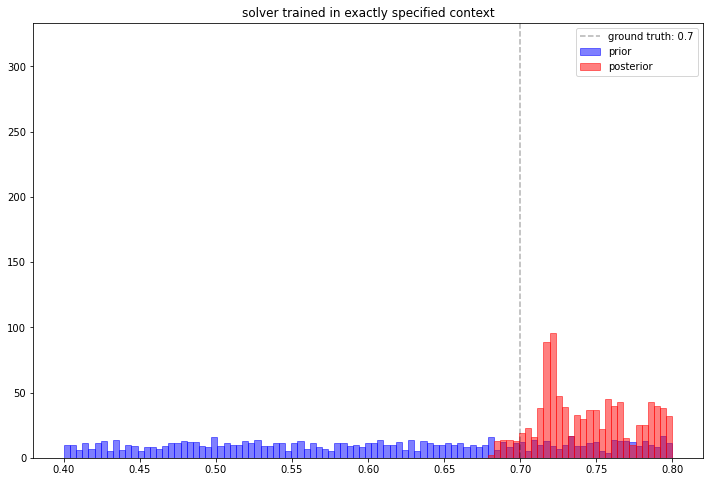

In [9]:
# Plot

fig, ax = plt.subplots()
HIST_BINS = np.linspace(0.4, 0.8, 100)
ax.hist(context_history_exact[0][:, 2], HIST_BINS, lw=1,
        ec="blue", fc="blue", alpha=0.5)
ax.hist(context_history_exact[-1][:, 2], HIST_BINS, lw=1,
        ec="red", fc="red", alpha=0.5)
plt.axvline(x=0.7, alpha=0.3, color='black', linestyle='--')
plt.legend(['ground truth: 0.7', 'prior', 'posterior'])
ax.set_ylim(top=N / 3)
fig.set_size_inches(12, 8)
plt.title('solver trained in exactly specified context')
plt.show()

### b. Misspecified context

In [10]:
# We reduce the theta from 0.7 to 0.5 and keep others the same. 
c_mis = {"context_distribution":
        ConstantDistribution(dim=5, constant_vector=np.array([0.98, 0.15, 0.5, 0.7, 0.15]))
    }

ray.shutdown()
ray.init()

solver_mis = ppo.PPOTrainer(env=cMDPWhited, config={
    "env_config": c_mis,
    "framework": "torch",  # config to pass to env class
})

rews = []
for eps in range(35):
    res = solver_mis.train()
    if eps % 5 == 0:
        print(eps, res['episode_reward_mean'])
    rews += [res['episode_reward_mean']]

2022-03-14 22:23:54,290	WARNING util.py:57 -- Install gputil for GPU system monitoring.
2022-03-14 22:24:06,225	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 2944157950861.0x the scale of `vf_clip_param`. This means that it will take more than 2944157950861.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.


0 -29441579508608.75


2022-03-14 22:24:18,344	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 1488536918898.0x the scale of `vf_clip_param`. This means that it will take more than 1488536918898.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-14 22:24:30,521	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 138563384103.0x the scale of `vf_clip_param`. This means that it will take more than 138563384103.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-14 22:24:42,594	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 12996312738.0x the scale of `vf_clip_param`. This means that it will take more than 12996312738.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-14 22:24:54,595	WARNING ppo.py:245 -- The magnitude of y

5 -1212971249.2273214


2022-03-14 22:25:18,628	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 12315834.0x the scale of `vf_clip_param`. This means that it will take more than 12315834.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-14 22:25:30,606	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 582848.0x the scale of `vf_clip_param`. This means that it will take more than 582848.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-14 22:25:42,514	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 139731.0x the scale of `vf_clip_param`. This means that it will take more than 139731.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-14 22:25:54,437	WARNING ppo.py:245 -- The magnitude of your environment rewards are more

10 -72058.59116205986


2022-03-14 22:26:18,201	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 983.0x the scale of `vf_clip_param`. This means that it will take more than 983.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.


15 92.45116088168868
20 150.43144600935278
25 153.76226420172787
30 154.77311344961413


In [255]:
c_sim = {"context_distribution":
        ConstantDistribution(dim=5, constant_vector=np.array([0.98, 0.15, 0.7, 0.7, 0.15]))
         }

context_mis_multi, context_mean_mis_multi = multi_round_context(expert,
                                                                c_sim,
                                                                solver_mis,
                                                                context_particles,
                                                                T,
                                                                N,
                                                                10,
                                                                2)

round 0 posterior mean 0.6070124320747413
round 25 posterior mean 0.6046085954785885
round 50 posterior mean 0.5919928651485689
round 75 posterior mean 0.6038460487431314
round 0
round 0 posterior mean 0.6070124320747413
round 25 posterior mean 0.625086256281719
round 50 posterior mean 0.6430253229822785
round 75 posterior mean 0.6090246252323847
round 1
round 0 posterior mean 0.6070124320747413
round 25 posterior mean 0.6102200612217638
round 50 posterior mean 0.6089800522283799
round 75 posterior mean 0.5947012410589139
round 2
round 0 posterior mean 0.6070124320747413
round 25 posterior mean 0.6052501435997174
round 50 posterior mean 0.5673162301782209
round 75 posterior mean 0.5742288838353513
round 3
round 0 posterior mean 0.6070124320747413
round 25 posterior mean 0.6014697258282835
round 50 posterior mean 0.5787514187735219
round 75 posterior mean 0.5920486965003368
round 4
round 0 posterior mean 0.6070124320747413
round 25 posterior mean 0.6194422431414441
round 50 posterior me

In [257]:
np.save("context_mis.npy", context_mis_multi)
np.save("context_mean_mis.npy", context_mean_mis_multi)

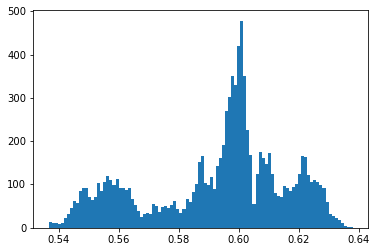

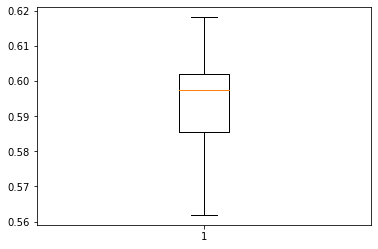

In [256]:
plt.hist(context_mis_multi, bins=100)
plt.show()
plt.boxplot(context_mean_mis_multi)
plt.show()

In [11]:
# Estimation

N = 1000
T = 100

gamma = np.ones((N,)) * 0.98
delta = np.ones((N,)) * 0.15
theta = np.random.uniform(0.4, 0.8, size=(N,))
rho = np.ones((N,)) * 0.7
sigma = np.ones((N,)) * 0.15

context_particles = np.abs(np.vstack((gamma, delta, theta, rho, sigma)).T)
context_distribution = ParticleDistribution(dim=5, particles=context_particles, n_particles=N)

context_history_mis, _ = filter_context(solver_mis,
                                          context_distribution,
                                          gt_obs_arr,
                                          T,
                                          N
                                          )

round 0 posterior mean 0.6012733577760675
round 25 posterior mean 0.6306228200737602
round 50 posterior mean 0.6367544020680284
round 75 posterior mean 0.6400664354243674


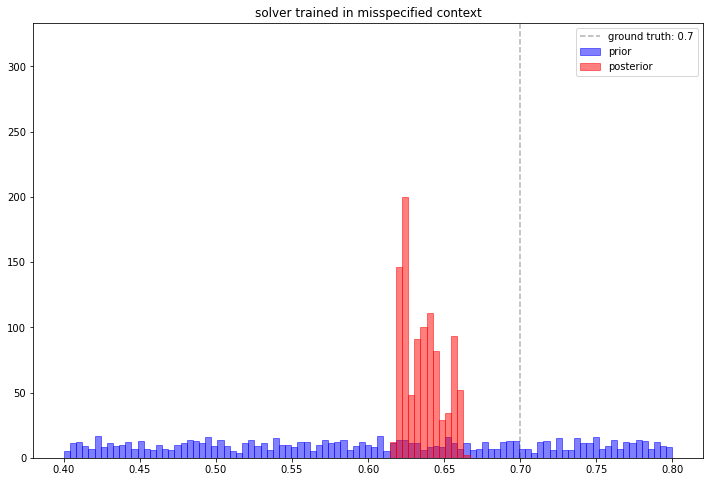

In [12]:
# Plot

fig, ax = plt.subplots()
HIST_BINS = np.linspace(0.4, 0.8, 100)
ax.hist(context_history_mis[0][:, 2], HIST_BINS, lw=1,
        ec="blue", fc="blue", alpha=0.5)
ax.hist(context_history_mis[-1][:, 2], HIST_BINS, lw=1,
        ec="red", fc="red", alpha=0.5)
plt.axvline(x=0.7, alpha=0.3, color='black', linestyle='--')
plt.legend(['ground truth: 0.7', 'prior', 'posterior'])
ax.set_ylim(top=N / 3)
fig.set_size_inches(12, 8)
plt.title('solver trained in misspecified context')
plt.show()

### c. Uniformly sampled context

In [13]:
# Uniformly sample theta between 0.6 and 1.0
c_uniform = {'context_distribution':
             UniformDistribution(dim=5,
                                 lower_bound_vector=np.array([0.98, 0.15, 0.4, 0.7, 0.15]),
                                 upper_bound_vector=np.array([0.98, 0.15, 0.8, 0.7, 0.15]))}

ray.shutdown()
ray.init()
solver_uniform = ppo.PPOTrainer(env=cMDPWhited, config={
                                                    "env_config": c_uniform,
                                                    "framework": "torch",  # config to pass to env class
                                                })

rews = []
for eps in range(35):
    res = solver_uniform.train()
    if eps % 5 == 0:
        print(eps, res['episode_reward_mean'])
    rews += [res['episode_reward_mean']]

2022-03-14 22:32:57,568	WARNING util.py:57 -- Install gputil for GPU system monitoring.
2022-03-14 22:33:09,601	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 432829387641.0x the scale of `vf_clip_param`. This means that it will take more than 432829387641.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.


0 -4328293876406.7593


2022-03-14 22:33:21,619	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 247776432274.0x the scale of `vf_clip_param`. This means that it will take more than 247776432274.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-14 22:33:33,656	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 62417898576.0x the scale of `vf_clip_param`. This means that it will take more than 62417898576.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-14 22:33:45,671	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 9211556366.0x the scale of `vf_clip_param`. This means that it will take more than 9211556366.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-14 22:33:57,633	WARNING ppo.py:245 -- The magnitude of your en

5 -1561276684.068978


2022-03-14 22:34:21,706	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 816496.0x the scale of `vf_clip_param`. This means that it will take more than 816496.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-14 22:34:33,702	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 150721.0x the scale of `vf_clip_param`. This means that it will take more than 150721.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-14 22:34:45,655	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 21810.0x the scale of `vf_clip_param`. This means that it will take more than 21810.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-14 22:34:57,661	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 

10 -711.3621816438609
15 297.6027969058187
20 331.8397889716725
25 345.41829433393804
30 407.49270852338566


In [258]:
c_sim = {"context_distribution":
        ConstantDistribution(dim=5, constant_vector=np.array([0.98, 0.15, 0.7, 0.7, 0.15]))
         }

context_uniform_multi, context_mean_uniform_multi = multi_round_context(expert,
                                                                c_sim,
                                                                solver_uniform,
                                                                context_particles,
                                                                T,
                                                                N,
                                                                30,
                                                                2)

round 0 posterior mean 0.6070124320747413


c:\Users\ZhenghaoJiang\Documents\GitHub\cmdp\mdps\whited.py:124: RuntimeWarning: invalid value encountered in log
  eps = np.log(z_curr)-rho*np.log(z_prev)


round 25 posterior mean 0.6816324987680898
round 50 posterior mean 0.7053613340579281
round 75 posterior mean 0.7148380573788452
round 0
round 0 posterior mean 0.6070124320747413
round 25 posterior mean 0.7667610576862901
round 50 posterior mean 0.7887533572704223
round 75 posterior mean 0.7880709157095181
round 1
round 0 posterior mean 0.6070124320747413
round 25 posterior mean 0.7572856640419104
round 50 posterior mean 0.7624997105378384
round 75 posterior mean 0.7634800635755966
round 2
round 0 posterior mean 0.6070124320747413
round 25 posterior mean 0.7202707120806086
round 50 posterior mean 0.74180884142756
round 75 posterior mean 0.7573921716685705
round 3
round 0 posterior mean 0.6070124320747413
round 25 posterior mean 0.725242044515508
round 50 posterior mean 0.7645921193003021
round 75 posterior mean 0.7954017489009092
round 4
round 0 posterior mean 0.6070124320747413
round 25 posterior mean 0.7123000591662749
round 50 posterior mean 0.74975540176322
round 75 posterior mean 

In [259]:
np.save("context_uniform.npy", context_uniform_multi)
np.save("context_mean_uniform.npy", context_mean_uniform_multi)

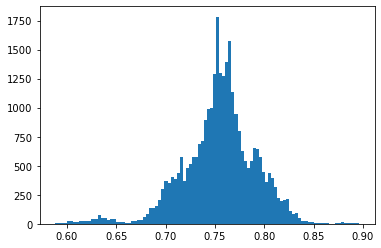

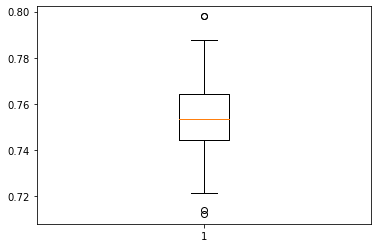

In [260]:
plt.hist(context_uniform_multi, bins=100)
plt.show()
plt.boxplot(context_mean_uniform_multi)
plt.show()

In [14]:
# Estimation

N = 1000
T = 100

gamma = np.ones((N,)) * 0.98
delta = np.ones((N,)) * 0.15
theta = np.random.uniform(0.4, 0.8, size=(N,))
rho = np.ones((N,)) * 0.7
sigma = np.ones((N,)) * 0.15

context_particles = np.abs(np.vstack((gamma, delta, theta, rho, sigma)).T)
context_distribution = ParticleDistribution(dim=5, particles=context_particles, n_particles=N)

context_history_uniform, _ = filter_context(solver_uniform,
                                          context_distribution,
                                          gt_obs_arr,
                                          T,
                                          N
                                          )

round 0 posterior mean 0.5957402200936915
round 25 posterior mean 0.6929202219862611
round 50 posterior mean 0.6449194291540986
round 75 posterior mean 0.6404698719575262


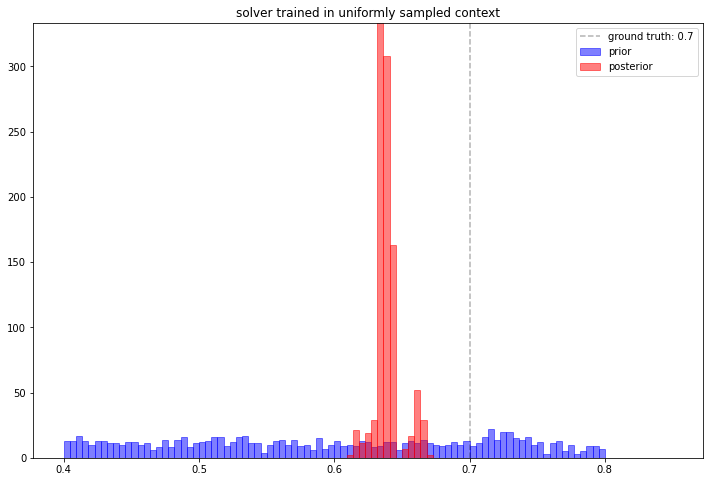

In [15]:
# Plot

fig, ax = plt.subplots()
HIST_BINS = np.linspace(0.4, 0.85, 100)
ax.hist(context_history_uniform[0][:, 2], HIST_BINS, lw=1,
        ec="blue", fc="blue", alpha=0.5)
ax.hist(context_history_uniform[-1][:, 2], HIST_BINS, lw=1,
        ec="red", fc="red", alpha=0.5)
plt.axvline(x=0.7, alpha=0.3, color='black', linestyle='--')
plt.legend(['ground truth: 0.7', 'prior', 'posterior'])
ax.set_ylim(top=N / 3)
fig.set_size_inches(12, 8)
plt.title('solver trained in uniformly sampled context')
plt.show()

### d. Importance sampling

2022-03-14 22:41:59,914	WARNING util.py:57 -- Install gputil for GPU system monitoring.
2022-03-14 22:42:11,785	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 285021550433.0x the scale of `vf_clip_param`. This means that it will take more than 285021550433.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-14 22:42:23,741	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 176205764433.0x the scale of `vf_clip_param`. This means that it will take more than 176205764433.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-14 22:42:35,754	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 63970209470.0x the scale of `vf_clip_param`. This means that it will take more than 63970209470.0 iterations for your value function to converge. If this is not intended, consider increa

round 0 posterior mean 0.6006542343785466
round 25 posterior mean 0.8284466861724233
round 50 posterior mean 0.8270662723467357
round 75 posterior mean 0.8312070929013925


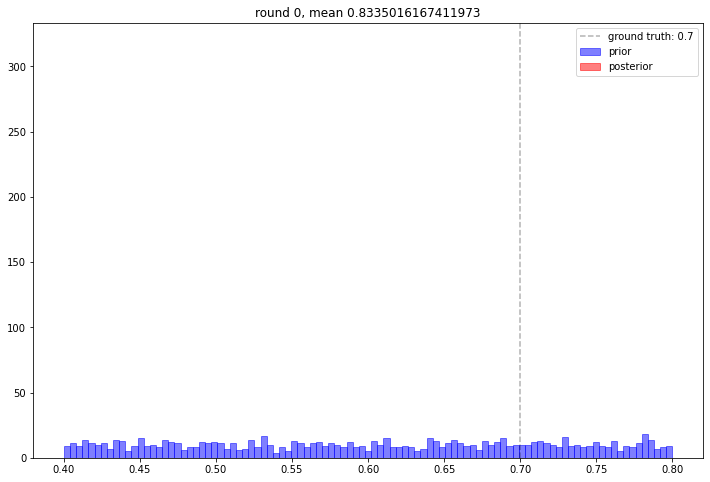

round 0 posterior mean 0.8335016167411973
round 25 posterior mean 0.8323202103574431
round 50 posterior mean 0.8331390504699759
round 75 posterior mean 0.8275884158623394


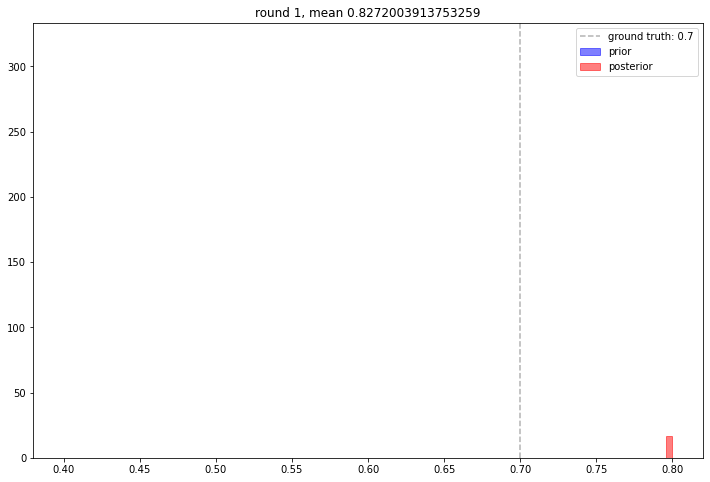

2022-03-14 22:50:54,181	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 218.0x the scale of `vf_clip_param`. This means that it will take more than 218.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-14 22:51:06,041	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 242.0x the scale of `vf_clip_param`. This means that it will take more than 242.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-14 22:51:17,888	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 267.0x the scale of `vf_clip_param`. This means that it will take more than 267.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-14 22:51:29,695	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 277.0x the scale

round 0 posterior mean 0.8272003913753259
round 25 posterior mean 0.8269238713494468
round 50 posterior mean 0.8299210417236911
round 75 posterior mean 0.8255551280839623


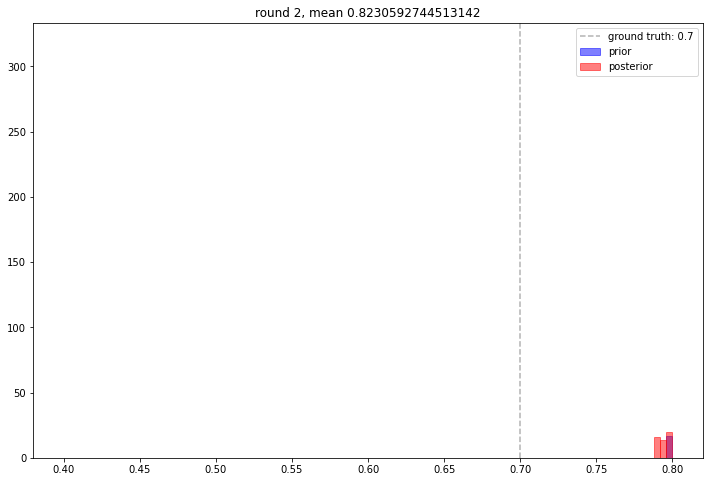

2022-03-14 22:53:44,748	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 314.0x the scale of `vf_clip_param`. This means that it will take more than 314.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-14 22:53:56,619	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 335.0x the scale of `vf_clip_param`. This means that it will take more than 335.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-14 22:54:08,528	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 349.0x the scale of `vf_clip_param`. This means that it will take more than 349.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-14 22:54:20,146	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 377.0x the scale

round 0 posterior mean 0.8230592744513142
round 25 posterior mean 0.8260540141004301
round 50 posterior mean 0.8307947180034956
round 75 posterior mean 0.8356906205451933


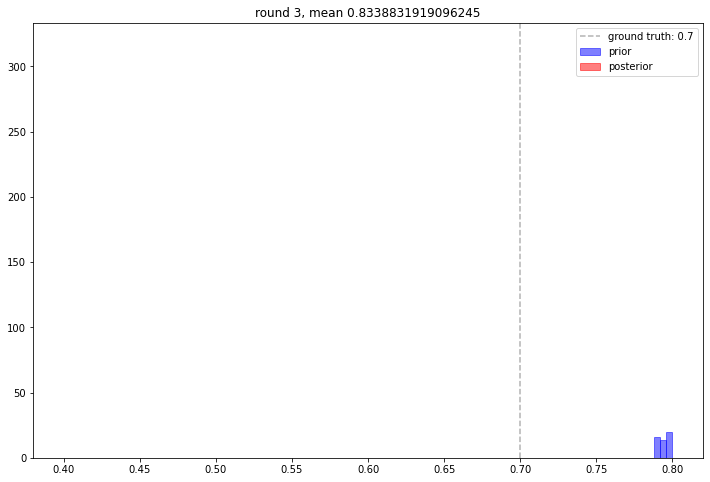

In [16]:
# Initialize prior

N = 1000
T = 100

gamma = np.ones((N,)) * 0.98
delta = np.ones((N,)) * 0.15
theta = np.random.uniform(0.4, 0.8, size=(N,))
rho = np.ones((N,)) * 0.7
sigma = np.ones((N,)) * 0.15

prior_context_particles = np.abs(np.vstack((gamma, delta, theta, rho, sigma)).T)
imp_context_distribution = ParticleDistribution(dim=5, particles=prior_context_particles, n_particles=N)

ray.shutdown()
ray.init()

imp_solver = ppo.PPOTrainer(env=cMDPWhited, config={
                                                "env_config":  {"context_distribution": imp_context_distribution},
                                                "framework": "torch",  # config to pass to env class
                                            })

for update_round in range(4):
    # burn in training
    if update_round == 0:
        for i in range(20):
            imp_solver.train()

    context_history_imp, imp_context_distribution = filter_context(imp_solver,
                                       imp_context_distribution,
                                       gt_obs_arr,
                                       T,
                                       N
                                       )

    fig, ax = plt.subplots()
    HIST_BINS = np.linspace(0.4, 0.8, 100)
    ax.hist(context_history_imp[0][:, 2], HIST_BINS, lw=1,
            ec="blue", fc="blue", alpha=0.5)
    ax.hist(context_history_imp[-1][:, 2], HIST_BINS, lw=1,
            ec="red", fc="red", alpha=0.5)
    plt.axvline(x=0.7, alpha=0.3, color='black', linestyle='--')
    plt.legend(['ground truth: 0.7', 'prior', 'posterior'])
    ax.set_ylim(top=N / 3)
    fig.set_size_inches(12, 8)
    plt.title(f'round {update_round}, mean {context_history_imp[-1][:, 2].mean()}')
    plt.show()

    imp_solver.workers.foreach_worker(
                lambda ev: ev.foreach_env(
                    lambda env: env.set_task(imp_context_distribution)))
    if update_round < 3:
        for _ in range(5):
            imp_solver.train()


In [269]:
def multi_round_imp_context(sim_solver_,
                            sim_config_,
                            context_particles_,
                            T_,
                            N_,
                            n_trajectory_,
                            n_round_,
                            which_param_
                            ):
    context_ = None
    context_mean_ = None
    for i_ in range(n_trajectory_):
        
        gt_obs_arr_, _, _ = get_rollouts(sim_solver_, config=sim_config_)

        for j_ in range(n_round_):
            imp_context_distribution_ = ParticleDistribution(dim=5, particles=context_particles_, n_particles=N_)

            ray.shutdown()
            ray.init()

            imp_solver_ = ppo.PPOTrainer(env=cMDPWhited, config={
                                                            "env_config":  {"context_distribution": imp_context_distribution_},
                                                            "framework": "torch",
                                                        })

            for update_round in range(4):
                # burn in training
                if update_round == 0:
                    for i in range(20):
                        imp_solver_.train()

                context_history_imp_, imp_context_distribution_ = filter_context(imp_solver_,
                                                                                imp_context_distribution_,
                                                                                gt_obs_arr_,
                                                                                T_,
                                                                                N_
                                                                                )

                imp_solver_.workers.foreach_worker(
                            lambda ev: ev.foreach_env(
                                lambda env: env.set_task(imp_context_distribution_)))
                if update_round < 3:
                    for _ in range(5):
                        imp_solver_.train()
            context_curr_ = context_history_imp_[-1][:,which_param_]
            if context_ is None:
                context_ = context_curr_
                context_mean_ = [context_curr_.mean()]
            else:
                context_ = np.concatenate((context_, context_curr_))
                context_mean_ += [context_curr_.mean()]
            print("round", (i_ + 1, j_ + 1))
    context_mean_ = np.array(context_mean_)

    return context_, context_mean_

In [270]:
c_sim = {"context_distribution":
        ConstantDistribution(dim=5, constant_vector=np.array([0.98, 0.15, 0.7, 0.7, 0.15]))
         }

context_imp_multi, context_mean_imp_multi = multi_round_imp_context(expert,
                                                                c_sim,
                                                                context_particles,
                                                                T,
                                                                N,
                                                                15,
                                                                2)

2022-03-03 09:25:07,272	WARNING util.py:57 -- Install gputil for GPU system monitoring.
2022-03-03 09:25:16,475	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 703113985870.0x the scale of `vf_clip_param`. This means that it will take more than 703113985870.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-03 09:25:26,056	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 369137157858.0x the scale of `vf_clip_param`. This means that it will take more than 369137157858.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-03 09:25:35,286	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 268941609398.0x the scale of `vf_clip_param`. This means that it will take more than 268941609398.0 iterations for your value function to converge. If this is not intended, consider incr

round 0 posterior mean 0.6070124320747413


c:\Users\ZhenghaoJiang\Documents\GitHub\cmdp\mdps\whited.py:124: RuntimeWarning: invalid value encountered in log
  eps = np.log(z_curr)-rho*np.log(z_prev)


round 25 posterior mean 0.7071819711903583
round 50 posterior mean 0.7394972266379174
round 75 posterior mean 0.7274899200199454
round 0 posterior mean 0.7426336537772034
round 25 posterior mean 0.7547167392274294
round 50 posterior mean 0.744325352758944
round 75 posterior mean 0.7688267656457528
round 0 posterior mean 0.7675872321261589
round 25 posterior mean 0.7633470123182551
round 50 posterior mean 0.7530294208335652
round 75 posterior mean 0.7418873362545114
round 0 posterior mean 0.7331672927239306
round 25 posterior mean 0.7615875428319402
round 50 posterior mean 0.7449813252836114
round 75 posterior mean 0.7318095874183214
round 0


2022-03-03 09:36:12,120	WARNING util.py:57 -- Install gputil for GPU system monitoring.
2022-03-03 09:36:21,118	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 713113281623.0x the scale of `vf_clip_param`. This means that it will take more than 713113281623.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-03 09:36:30,196	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 361904022382.0x the scale of `vf_clip_param`. This means that it will take more than 361904022382.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-03 09:36:39,333	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 161070390874.0x the scale of `vf_clip_param`. This means that it will take more than 161070390874.0 iterations for your value function to converge. If this is not intended, consider incr

round 0 posterior mean 0.6070124320747413
round 25 posterior mean 0.7643571877721926
round 50 posterior mean 0.7700927883102779
round 75 posterior mean 0.7679801353731814
round 0 posterior mean 0.7714726548786005
round 25 posterior mean 0.7763659682789139
round 50 posterior mean 0.7736052672211826
round 75 posterior mean 0.7712661061908446
round 0 posterior mean 0.7691087763760202
round 25 posterior mean 0.7663110554988322
round 50 posterior mean 0.764271846980778
round 75 posterior mean 0.7632927544428328


2022-03-03 09:45:32,095	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 211.0x the scale of `vf_clip_param`. This means that it will take more than 211.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-03 09:45:41,055	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 210.0x the scale of `vf_clip_param`. This means that it will take more than 210.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-03 09:45:49,998	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 212.0x the scale of `vf_clip_param`. This means that it will take more than 212.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-03 09:45:59,383	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 217.0x the scale

round 0 posterior mean 0.7579191544751744
round 25 posterior mean 0.759935937895092
round 50 posterior mean 0.7570069897529098
round 75 posterior mean 0.7590303972692218
round 1


2022-03-03 09:47:49,100	WARNING util.py:57 -- Install gputil for GPU system monitoring.
2022-03-03 09:47:58,096	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 775080116185.0x the scale of `vf_clip_param`. This means that it will take more than 775080116185.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-03 09:48:07,065	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 390929375306.0x the scale of `vf_clip_param`. This means that it will take more than 390929375306.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-03 09:48:15,935	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 255809867524.0x the scale of `vf_clip_param`. This means that it will take more than 255809867524.0 iterations for your value function to converge. If this is not intended, consider incr

round 0 posterior mean 0.6070124320747413
round 25 posterior mean 0.7132973553130594
round 50 posterior mean 0.7670474650405225
round 75 posterior mean 0.7702336979293386
round 0 posterior mean 0.7703190660505548
round 25 posterior mean 0.7748717495108449
round 50 posterior mean 0.771347060314029
round 75 posterior mean 0.7661263952241784
round 0 posterior mean 0.769725650397754
round 25 posterior mean 0.7722322409431281
round 50 posterior mean 0.7766527804543005
round 75 posterior mean 0.7722813636878127


2022-03-03 09:57:00,838	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 205.0x the scale of `vf_clip_param`. This means that it will take more than 205.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-03 09:57:09,771	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 219.0x the scale of `vf_clip_param`. This means that it will take more than 219.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.


round 0 posterior mean 0.7713842160983185
round 25 posterior mean 0.7693543772326771
round 50 posterior mean 0.7695734411276205
round 75 posterior mean 0.7695598505189661
round 2


2022-03-03 09:58:46,362	WARNING util.py:57 -- Install gputil for GPU system monitoring.
2022-03-03 09:58:55,356	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 1425080781770.0x the scale of `vf_clip_param`. This means that it will take more than 1425080781770.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-03 09:59:04,417	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 743641978106.0x the scale of `vf_clip_param`. This means that it will take more than 743641978106.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-03 09:59:13,383	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 248682105463.0x the scale of `vf_clip_param`. This means that it will take more than 248682105463.0 iterations for your value function to converge. If this is not intended, consider in

round 0 posterior mean 0.6070124320747413
round 25 posterior mean 0.7260868777118417
round 50 posterior mean 0.7272585006904548
round 75 posterior mean 0.7271446043854101
round 0 posterior mean 0.7473718971065486
round 25 posterior mean 0.7600076943112901
round 50 posterior mean 0.7603374665376195
round 75 posterior mean 0.7638884435319839
round 0 posterior mean 0.7709688480400403
round 25 posterior mean 0.7715171832606943
round 50 posterior mean 0.766808269475045
round 75 posterior mean 0.7700853831899972


2022-03-03 10:08:16,915	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 201.0x the scale of `vf_clip_param`. This means that it will take more than 201.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.


round 0 posterior mean 0.7660088716770797
round 25 posterior mean 0.7706722333706377
round 50 posterior mean 0.7593402082886551
round 75 posterior mean 0.7660389316270152
round 3


2022-03-03 10:09:57,725	WARNING util.py:57 -- Install gputil for GPU system monitoring.
2022-03-03 10:10:06,870	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 2084960886526.0x the scale of `vf_clip_param`. This means that it will take more than 2084960886526.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-03 10:10:16,156	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 1056850775297.0x the scale of `vf_clip_param`. This means that it will take more than 1056850775297.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-03 10:10:25,414	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 682745542443.0x the scale of `vf_clip_param`. This means that it will take more than 682745542443.0 iterations for your value function to converge. If this is not intended, consider 

round 0 posterior mean 0.6070124320747413
round 25 posterior mean 0.7069998079003473
round 50 posterior mean 0.7252213607404785
round 75 posterior mean 0.7219854331074852
round 0 posterior mean 0.7248059582520532
round 25 posterior mean 0.7336251379030329
round 50 posterior mean 0.7500824836398802
round 75 posterior mean 0.7559919277376591
round 0 posterior mean 0.7458201117777625
round 25 posterior mean 0.7539731689553173
round 50 posterior mean 0.761108849428964
round 75 posterior mean 0.7553033874728796
round 0 posterior mean 0.757327999072797
round 25 posterior mean 0.7651019977907988
round 50 posterior mean 0.771339421414345
round 75 posterior mean 0.7672678277589408
round 4


2022-03-03 10:21:08,577	WARNING util.py:57 -- Install gputil for GPU system monitoring.
2022-03-03 10:21:17,949	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 1705477692788.0x the scale of `vf_clip_param`. This means that it will take more than 1705477692788.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-03 10:21:27,293	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 876366620025.0x the scale of `vf_clip_param`. This means that it will take more than 876366620025.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-03 10:21:36,482	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 330503860800.0x the scale of `vf_clip_param`. This means that it will take more than 330503860800.0 iterations for your value function to converge. If this is not intended, consider in

round 0 posterior mean 0.6070124320747413
round 25 posterior mean 0.7437116726401969
round 50 posterior mean 0.7479978234315715
round 75 posterior mean 0.7638500489796833
round 0 posterior mean 0.7622299574205158
round 25 posterior mean 0.7828615477638443
round 50 posterior mean 0.7813551317364962
round 75 posterior mean 0.781249558470194


2022-03-03 10:27:58,687	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 216.0x the scale of `vf_clip_param`. This means that it will take more than 216.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-03 10:28:07,743	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 252.0x the scale of `vf_clip_param`. This means that it will take more than 252.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-03 10:28:16,738	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 296.0x the scale of `vf_clip_param`. This means that it will take more than 296.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-03 10:28:25,733	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 341.0x the scale

round 0 posterior mean 0.7885827205950812
round 25 posterior mean 0.790136981829219
round 50 posterior mean 0.786079000109916
round 75 posterior mean 0.7877397868842018


2022-03-03 10:29:57,406	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 333.0x the scale of `vf_clip_param`. This means that it will take more than 333.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-03 10:30:06,427	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 323.0x the scale of `vf_clip_param`. This means that it will take more than 323.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-03 10:30:15,389	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 338.0x the scale of `vf_clip_param`. This means that it will take more than 338.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-03 10:30:24,421	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 357.0x the scale

round 0 posterior mean 0.7834886393645261
round 25 posterior mean 0.7910604383211123
round 50 posterior mean 0.7957763815866694
round 75 posterior mean 0.7926094741432355
round 5


2022-03-03 10:32:11,143	WARNING util.py:57 -- Install gputil for GPU system monitoring.
2022-03-03 10:32:20,116	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 1887297427401.0x the scale of `vf_clip_param`. This means that it will take more than 1887297427401.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-03 10:32:29,214	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 1015308129584.0x the scale of `vf_clip_param`. This means that it will take more than 1015308129584.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-03 10:32:38,210	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 764607179881.0x the scale of `vf_clip_param`. This means that it will take more than 764607179881.0 iterations for your value function to converge. If this is not intended, consider 

round 0 posterior mean 0.6070124320747413
round 25 posterior mean 0.7293237069396287
round 50 posterior mean 0.7382901967453561
round 75 posterior mean 0.7354076511044108
round 0 posterior mean 0.7318963771971154
round 25 posterior mean 0.7504910666960325
round 50 posterior mean 0.7449236960080857
round 75 posterior mean 0.7463329277117418
round 0 posterior mean 0.7474986017414691
round 25 posterior mean 0.7492904340916907
round 50 posterior mean 0.7331711272577183
round 75 posterior mean 0.7320897337760761
round 0 posterior mean 0.7326212036666737
round 25 posterior mean 0.7453182493290602
round 50 posterior mean 0.7446440303065219
round 75 posterior mean 0.7282145061457718
round 6


2022-03-03 10:43:09,219	WARNING util.py:57 -- Install gputil for GPU system monitoring.
2022-03-03 10:43:17,793	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 6734475370067.0x the scale of `vf_clip_param`. This means that it will take more than 6734475370067.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-03 10:43:26,430	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 3396917958447.0x the scale of `vf_clip_param`. This means that it will take more than 3396917958447.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-03 10:43:34,988	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 278692899479.0x the scale of `vf_clip_param`. This means that it will take more than 278692899479.0 iterations for your value function to converge. If this is not intended, consider 

round 0 posterior mean 0.6070124320747413
round 25 posterior mean 0.7157626396897885
round 50 posterior mean 0.7233888480682438
round 75 posterior mean 0.7220406421168266
round 0 posterior mean 0.7371614764397557
round 25 posterior mean 0.743492865317151
round 50 posterior mean 0.7462647876470884
round 75 posterior mean 0.7574558850024998


2022-03-03 10:50:00,310	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 213.0x the scale of `vf_clip_param`. This means that it will take more than 213.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.


round 0 posterior mean 0.7670371840950441
round 25 posterior mean 0.7749759078733548
round 50 posterior mean 0.7715176185168483
round 75 posterior mean 0.7675297059994493


2022-03-03 10:51:28,269	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 229.0x the scale of `vf_clip_param`. This means that it will take more than 229.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-03 10:51:36,683	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 253.0x the scale of `vf_clip_param`. This means that it will take more than 253.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-03 10:51:45,188	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 264.0x the scale of `vf_clip_param`. This means that it will take more than 264.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-03 10:51:53,651	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 267.0x the scale

round 0 posterior mean 0.7695053448674961
round 25 posterior mean 0.7738215122897429
round 50 posterior mean 0.7545886416905981
round 75 posterior mean 0.7434014538372794
round 7


2022-03-03 10:53:34,499	WARNING util.py:57 -- Install gputil for GPU system monitoring.
2022-03-03 10:53:42,961	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 688276595760.0x the scale of `vf_clip_param`. This means that it will take more than 688276595760.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-03 10:53:51,466	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 387825165929.0x the scale of `vf_clip_param`. This means that it will take more than 387825165929.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-03 10:53:59,896	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 218683342006.0x the scale of `vf_clip_param`. This means that it will take more than 218683342006.0 iterations for your value function to converge. If this is not intended, consider incr

round 0 posterior mean 0.6070124320747413
round 25 posterior mean 0.7651088140578322
round 50 posterior mean 0.7938935871791193
round 75 posterior mean 0.7956275106481908
round 0 posterior mean 0.7952140716744789
round 25 posterior mean 0.7998877391143719
round 50 posterior mean 0.7933938516824162
round 75 posterior mean 0.7896819470814523


2022-03-03 11:00:08,497	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 216.0x the scale of `vf_clip_param`. This means that it will take more than 216.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-03 11:00:16,930	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 234.0x the scale of `vf_clip_param`. This means that it will take more than 234.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-03 11:00:25,428	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 257.0x the scale of `vf_clip_param`. This means that it will take more than 257.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.


round 0 posterior mean 0.7831760641745836
round 25 posterior mean 0.77233825359499
round 50 posterior mean 0.7716336082387218
round 75 posterior mean 0.7664090272635574


2022-03-03 11:01:52,316	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 248.0x the scale of `vf_clip_param`. This means that it will take more than 248.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-03 11:02:00,835	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 228.0x the scale of `vf_clip_param`. This means that it will take more than 228.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-03 11:02:09,297	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 226.0x the scale of `vf_clip_param`. This means that it will take more than 226.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-03 11:02:17,832	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 237.0x the scale

round 0 posterior mean 0.7654346886647638
round 25 posterior mean 0.7670190316167436
round 50 posterior mean 0.769089425654932
round 75 posterior mean 0.7697754968887479
round 8


2022-03-03 11:03:59,105	WARNING util.py:57 -- Install gputil for GPU system monitoring.
2022-03-03 11:04:07,563	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 3342224299301.0x the scale of `vf_clip_param`. This means that it will take more than 3342224299301.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-03 11:04:16,021	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 1722555133998.0x the scale of `vf_clip_param`. This means that it will take more than 1722555133998.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-03 11:04:24,452	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 244569689283.0x the scale of `vf_clip_param`. This means that it will take more than 244569689283.0 iterations for your value function to converge. If this is not intended, consider 

round 0 posterior mean 0.6070124320747413
round 25 posterior mean 0.728445803512141
round 50 posterior mean 0.7453272378062771
round 75 posterior mean 0.7290526207525254
round 0 posterior mean 0.7438169048397762
round 25 posterior mean 0.784350107212015
round 50 posterior mean 0.7820809744075843
round 75 posterior mean 0.7744982212972986
round 0 posterior mean 0.7737339630219212
round 25 posterior mean 0.7874366479703945
round 50 posterior mean 0.7810008610681425
round 75 posterior mean 0.7700011764240685
round 0 posterior mean 0.7568789053108487
round 25 posterior mean 0.7490479013300052
round 50 posterior mean 0.7420363415821761
round 75 posterior mean 0.7382200001058793
round 9


2022-03-03 11:14:23,309	WARNING util.py:57 -- Install gputil for GPU system monitoring.
2022-03-03 11:14:31,721	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 1900173381727.0x the scale of `vf_clip_param`. This means that it will take more than 1900173381727.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-03 11:14:40,166	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 980413516483.0x the scale of `vf_clip_param`. This means that it will take more than 980413516483.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-03 11:14:48,563	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 362324925217.0x the scale of `vf_clip_param`. This means that it will take more than 362324925217.0 iterations for your value function to converge. If this is not intended, consider in

round 0 posterior mean 0.6070124320747413
round 25 posterior mean 0.7256453393934511
round 50 posterior mean 0.739591513229711
round 75 posterior mean 0.7455309588705658
round 0 posterior mean 0.7498179957742162
round 25 posterior mean 0.7546782156330503
round 50 posterior mean 0.7542517777514047
round 75 posterior mean 0.7592059979986273
round 0 posterior mean 0.7592012041921737
round 25 posterior mean 0.7581169014579471
round 50 posterior mean 0.7573242655839542
round 75 posterior mean 0.7548672044514557
round 0 posterior mean 0.7550422207181116
round 25 posterior mean 0.7568684939167315
round 50 posterior mean 0.7485546778196451
round 75 posterior mean 0.7453653353707734
round 10


2022-03-03 11:24:49,440	WARNING util.py:57 -- Install gputil for GPU system monitoring.
2022-03-03 11:24:57,855	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 2042703695744.0x the scale of `vf_clip_param`. This means that it will take more than 2042703695744.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-03 11:25:06,403	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 1032774984769.0x the scale of `vf_clip_param`. This means that it will take more than 1032774984769.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-03 11:25:14,809	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 477657310244.0x the scale of `vf_clip_param`. This means that it will take more than 477657310244.0 iterations for your value function to converge. If this is not intended, consider 

round 0 posterior mean 0.6070124320747413
round 25 posterior mean 0.7238380192303953
round 50 posterior mean 0.7424465391669298
round 75 posterior mean 0.7309703598423348
round 0 posterior mean 0.7211484065649135
round 25 posterior mean 0.7231344826519305
round 50 posterior mean 0.7440934879522684
round 75 posterior mean 0.7402049842071396
round 0 posterior mean 0.7446606805627127
round 25 posterior mean 0.7552934083414606
round 50 posterior mean 0.7421709767501222
round 75 posterior mean 0.7347108464437324
round 0 posterior mean 0.7281518256570316
round 25 posterior mean 0.730513049781877
round 50 posterior mean 0.7334861416116975
round 75 posterior mean 0.7291369865813536
round 11


2022-03-03 11:35:12,420	WARNING util.py:57 -- Install gputil for GPU system monitoring.
2022-03-03 11:35:20,843	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 2973169739999.0x the scale of `vf_clip_param`. This means that it will take more than 2973169739999.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-03 11:35:29,391	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 1513373110372.0x the scale of `vf_clip_param`. This means that it will take more than 1513373110372.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-03 11:35:37,864	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 890147212029.0x the scale of `vf_clip_param`. This means that it will take more than 890147212029.0 iterations for your value function to converge. If this is not intended, consider 

round 0 posterior mean 0.6070124320747413
round 25 posterior mean 0.7249688847103625
round 50 posterior mean 0.7502165829521809
round 75 posterior mean 0.7861213820202335
round 0 posterior mean 0.7864021262121966
round 25 posterior mean 0.7927082783665104
round 50 posterior mean 0.7859404501302987
round 75 posterior mean 0.7835331672027549


2022-03-03 11:42:02,006	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 201.0x the scale of `vf_clip_param`. This means that it will take more than 201.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.


round 0 posterior mean 0.7848974918097898
round 25 posterior mean 0.790139491023648
round 50 posterior mean 0.7891710756097764
round 75 posterior mean 0.7879855490933003


2022-03-03 11:43:28,942	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 222.0x the scale of `vf_clip_param`. This means that it will take more than 222.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-03 11:43:37,374	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 244.0x the scale of `vf_clip_param`. This means that it will take more than 244.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-03 11:43:45,847	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 292.0x the scale of `vf_clip_param`. This means that it will take more than 292.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-03 11:43:54,281	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 356.0x the scale

round 0 posterior mean 0.7886663689837783
round 25 posterior mean 0.7854456899470666
round 50 posterior mean 0.7795357972746806
round 75 posterior mean 0.7737435474217302
round 12


2022-03-03 11:45:36,562	WARNING util.py:57 -- Install gputil for GPU system monitoring.
2022-03-03 11:45:44,947	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 692000212479.0x the scale of `vf_clip_param`. This means that it will take more than 692000212479.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-03 11:45:53,418	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 351718603008.0x the scale of `vf_clip_param`. This means that it will take more than 351718603008.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-03 11:46:01,833	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 180422753742.0x the scale of `vf_clip_param`. This means that it will take more than 180422753742.0 iterations for your value function to converge. If this is not intended, consider incr

round 0 posterior mean 0.6070124320747413
round 25 posterior mean 0.700735516037813
round 50 posterior mean 0.7075019320496604
round 75 posterior mean 0.7245177531148915
round 0 posterior mean 0.742772183660851
round 25 posterior mean 0.7328901970675338
round 50 posterior mean 0.7434264063066652
round 75 posterior mean 0.7344723890933967
round 0 posterior mean 0.7449581778466224
round 25 posterior mean 0.7394147980762396
round 50 posterior mean 0.7254470593157751
round 75 posterior mean 0.7302420736190802
round 0 posterior mean 0.7273307149085669
round 25 posterior mean 0.736502074088528
round 50 posterior mean 0.7364530091509615
round 75 posterior mean 0.7261829540612771
round 13


2022-03-03 11:56:03,704	WARNING util.py:57 -- Install gputil for GPU system monitoring.
2022-03-03 11:56:12,174	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 601717417163.0x the scale of `vf_clip_param`. This means that it will take more than 601717417163.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-03 11:56:20,733	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 320269101094.0x the scale of `vf_clip_param`. This means that it will take more than 320269101094.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-03 11:56:29,242	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 136757504267.0x the scale of `vf_clip_param`. This means that it will take more than 136757504267.0 iterations for your value function to converge. If this is not intended, consider incr

round 0 posterior mean 0.6070124320747413
round 25 posterior mean 0.669167201888261
round 50 posterior mean 0.676616724419493
round 75 posterior mean 0.6907072875988849
round 0 posterior mean 0.6869520858087323
round 25 posterior mean 0.7031706098354167
round 50 posterior mean 0.7636378895627788
round 75 posterior mean 0.7767840533189736
round 0 posterior mean 0.7903704827707172
round 25 posterior mean 0.7942139615509832
round 50 posterior mean 0.7983766195583628
round 75 posterior mean 0.7937420352849148
round 0 posterior mean 0.7908690644410208
round 25 posterior mean 0.7967555363640411
round 50 posterior mean 0.7999282563508511
round 75 posterior mean 0.7862563105612788
round 14


In [271]:
np.save("context_imp.npy", context_imp_multi)
np.save("context_mean_imp.npy", context_mean_imp_multi)

### e. Analysis

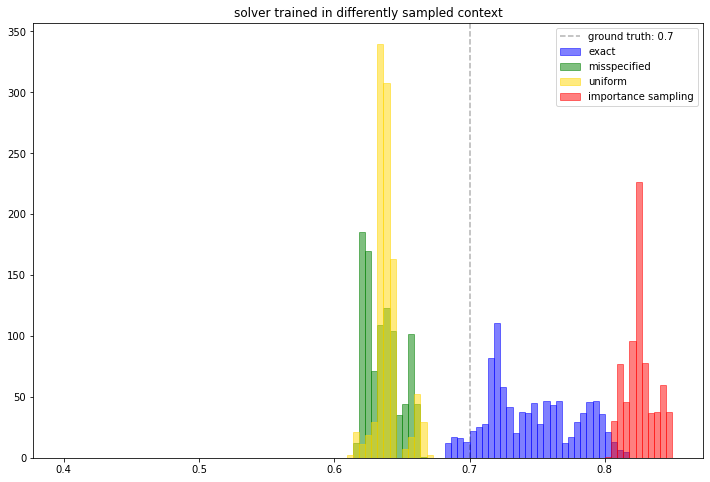

In [17]:
res_exact = context_history_exact[-1][:, 2]
res_mis = context_history_mis[-1][:, 2]
res_uniform = context_history_uniform[-1][:, 2]
res_imp = context_history_imp[-1][:, 2]
res = [res_exact, res_mis, res_uniform, res_imp]
# res = np.concatenate(([res_exact], [res_mis], [res_uniform], [res_imp]), axis=0)

fig, ax = plt.subplots()
HIST_BINS = np.linspace(0.4, 0.85, 100)
ax.hist(res[0], HIST_BINS, lw=1,
        ec="blue", fc="blue", alpha=0.5)
ax.hist(res[1], HIST_BINS, lw=1,
        ec="green", fc="green", alpha=0.5)
ax.hist(res[2], HIST_BINS, lw=1,
        ec="gold", fc="gold", alpha=0.5)
ax.hist(res[3], HIST_BINS, lw=1,
        ec="red", fc="red", alpha=0.5)
plt.axvline(x=0.7, alpha=0.3, color='black', linestyle='--')
plt.legend(['ground truth: 0.7', 'exact', 'misspecified', 'uniform', 'importance sampling'])
fig.set_size_inches(12, 8)
plt.title('solver trained in differently sampled context')
plt.show()

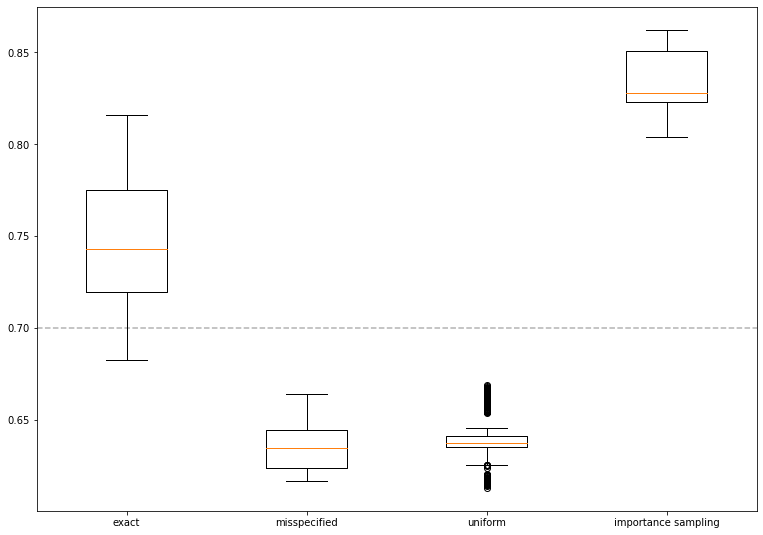

In [18]:
fig = plt.figure(figsize =(10, 7))
ax = fig.add_axes([0, 0, 1, 1])
ax.boxplot(res, labels=['exact', 'misspecified', 'uniform', 'importance sampling'])
plt.axhline(y=0.7, alpha=0.3, color='black', linestyle='--')
plt.show()

In [24]:
context_exact = np.load("context_exact_sigma.npy")
context_mis = np.load("context_mis_sigma.npy")
context_uniform = np.load("context_uniform_sigma.npy")
context_imp = np.load("context_imp_sigma.npy")
context_mean_exact = np.load("context_mean_exact_sigma.npy")
context_mean_mis = np.load("context_mean_mis_sigma.npy")
context_mean_uniform = np.load("context_mean_uniform_sigma.npy")
context_mean_imp = np.load("context_mean_imp_sigma.npy")

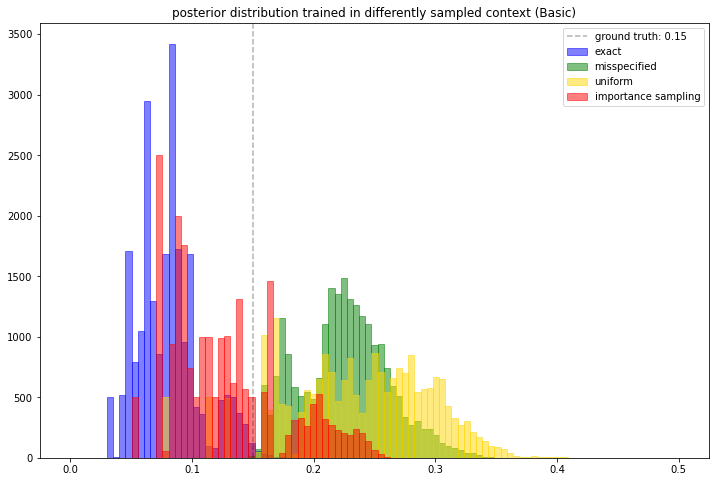

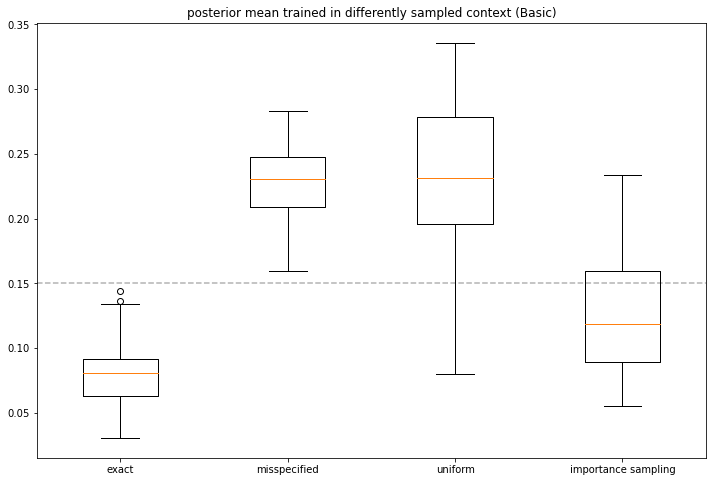

In [27]:
fig, ax = plt.subplots()
HIST_BINS = np.linspace(0.0, 0.5, 100)
ax.hist(context_exact, HIST_BINS, lw=1,
        ec="blue", fc="blue", alpha=0.5)
ax.hist(context_mis, HIST_BINS, lw=1,
        ec="green", fc="green", alpha=0.5)
ax.hist(context_uniform, HIST_BINS, lw=1,
        ec="gold", fc="gold", alpha=0.5)
ax.hist(context_imp, HIST_BINS, lw=1,
        ec="red", fc="red", alpha=0.5)
plt.axvline(x=0.15, alpha=0.3, color='black', linestyle='--')
plt.legend(['ground truth: 0.15', 'exact', 'misspecified', 'uniform', 'importance sampling'])
fig.set_size_inches(12, 8)
plt.title('posterior distribution trained in differently sampled context (Basic)')
plt.show()
# plt.savefig('basic_hist_sigma.pdf') 

res = [context_mean_exact, context_mean_mis, context_mean_uniform, context_mean_imp]
fig, ax = plt.subplots()
ax.boxplot(res, labels=['exact', 'misspecified', 'uniform', 'importance sampling'])
plt.axhline(y=0.15, alpha=0.3, color='black', linestyle='--')
plt.title('posterior mean trained in differently sampled context (Basic)')
fig.set_size_inches(12, 8)
plt.show()
# plt.savefig('basic_box_sigma.pdf') 

In [28]:
context_exact = np.load("context_exact.npy")
context_mis = np.load("context_mis.npy")
context_uniform = np.load("context_uniform.npy")
context_imp = np.load("context_imp.npy")
context_mean_exact = np.load("context_mean_exact.npy")
context_mean_mis = np.load("context_mean_mis.npy")
context_mean_uniform = np.load("context_mean_uniform.npy")
context_mean_imp = np.load("context_mean_imp.npy")

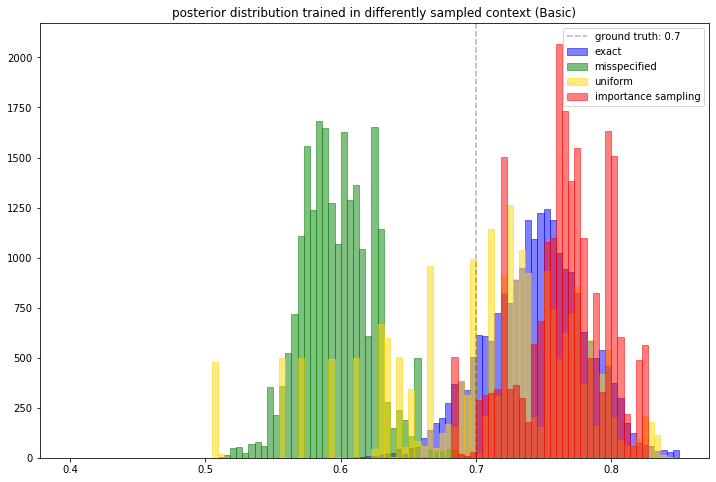

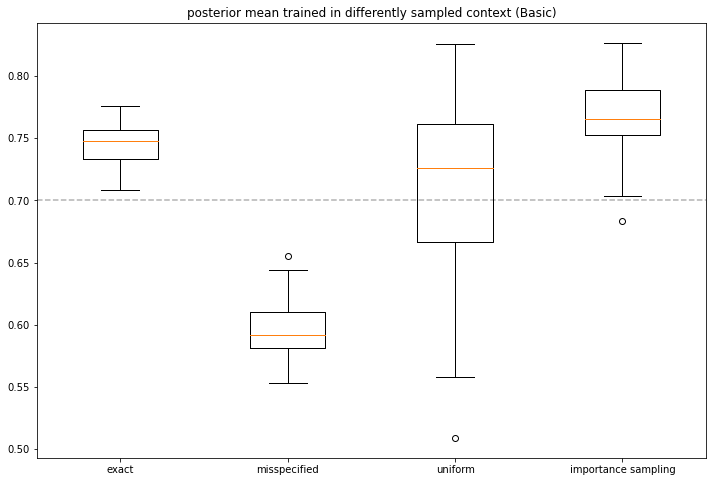

(pid=None) [2022-03-15 20:49:06,936 C 67120 14684] redis_client.cc:87:  Check failed: under_retry_limit Expected 1 Redis shard addresses, found 8104303535147543913
(pid=None) *** StackTrace Information ***
(pid=None)     recalloc
(pid=None)     BaseThreadInitThunk
(pid=None)     RtlUserThreadStart
(pid=None) 
2022-03-15 21:16:47,495	WARNING worker.py:1245 -- A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: ffffffffffffffff6608d3f7399fa4e76b6caaa601000000 Worker ID: 9f66bbfce378452844ee9544f12e91d78e9de5b0138e61952d9c2831 Node ID: 7b398a22f761eefabc46af6416c14f12e81fb4f9c8848d4b10b42fb1 Worker IP address: 127.0.0.1 Worker port: 50044 Worker PID: 49080
2022-03-15 21:16:47,502	WARNING worker.py:1245 -- A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: ffffffffffffffff5e21fc

In [29]:
fig, ax = plt.subplots()
HIST_BINS = np.linspace(0.4, 0.85, 100)
ax.hist(context_exact, HIST_BINS, lw=1,
        ec="blue", fc="blue", alpha=0.5)
ax.hist(context_mis, HIST_BINS, lw=1,
        ec="green", fc="green", alpha=0.5)
ax.hist(context_uniform, HIST_BINS, lw=1,
        ec="gold", fc="gold", alpha=0.5)
ax.hist(context_imp, HIST_BINS, lw=1,
        ec="red", fc="red", alpha=0.5)
plt.axvline(x=0.7, alpha=0.3, color='black', linestyle='--')
plt.legend(['ground truth: 0.7', 'exact', 'misspecified', 'uniform', 'importance sampling'])
fig.set_size_inches(12, 8)
plt.title('posterior distribution trained in differently sampled context (Basic)')
plt.show()
# plt.savefig('basic_hist_theta.pdf') 

res = [context_mean_exact, context_mean_mis, context_mean_uniform, context_mean_imp]
fig, ax = plt.subplots()
ax.boxplot(res, labels=['exact', 'misspecified', 'uniform', 'importance sampling'])
plt.axhline(y=0.7, alpha=0.3, color='black', linestyle='--')
plt.title('posterior mean trained in differently sampled context (Basic)')
fig.set_size_inches(12, 8)
plt.show()
# plt.savefig('basic_box_theta.pdf') 

---

## 1. Estiamtion for $\sigma$

In [307]:
def filter_context(solver_,
                   context_distribution_,
                   gt_obs_arr_,
                   T_,
                   N_
                   ):
    state_arr_ = np.ones((N_,2))
    action_arr_ = np.zeros((N_,))
    context_history_ = []
    for t_ in range(T_):
        # we only use the first 5 steps of the cartpole steps to reduce effect of different episode lengths
        qs_ = np.zeros((N_,))
        for n_ in range(N_):
            context_ = context_distribution_.particles[n_]
            c_local_ = {"context_distribution":
                           ConstantDistribution(dim=5,
                                                constant_vector=context_)
            }
            env_ = cMDPWhited(config=c_local_)
            obs_ = env_.reset()
            if t_ > 0:
                env_.mdp.state = state_arr_[n_]
                obs_ = np.concatenate((np.array(env_.mdp.state), context_), axis=0).flatten()
            action_ = solver_.compute_single_action(obs_)
            obs_, reward_, _, _ = env_.step(action_)
            # estimate likelihood if r >= 1
            action_arr_[n_] = action_
            q = env_.likelihood(gt_obs_arr_[t_], action_arr_[n_], obs_, reward_)
            qs_[n_] = q
            state_arr_[n_] = np.copy(env_.mdp.state)
        if t_ >= 1:
            # truncated importance sampling; [https://arxiv.org/pdf/1905.09800.pdf]
            qs_ = np.clip(qs_, 0, np.percentile(qs_, 90))
            if qs_.sum() == 0:
                continue
            qs_ = qs_ / qs_.sum()
            resample_index_ = context_distribution_.resample_particles_from_probability(p=qs_)
            p_temp_ = context_distribution_.particles
            p_noise_ = np.random.normal(loc=0, scale=p_temp_.std(axis=0), size=p_temp_.shape) * 0.2
            context_distribution_.particles += p_noise_
            context_distribution_.particles = np.clip(context_distribution_.particles, 0.0, 0.5)
            state_arr_ = state_arr_[resample_index_]
            action_arr_ = action_arr_[resample_index_]
        if t_ % 25 == 0:
            print("round", t_, "posterior mean", context_distribution_.particles[:, 4].mean())
        context_history_ += [context_distribution_.particles.copy()]
    return context_history_, context_distribution_

### a. Exact context

In [309]:
# Estimation

N = 1000
T = 100

gamma = np.ones((N,)) * 0.98
delta = np.ones((N,)) * 0.15
theta = np.ones((N,)) * 0.7
rho = np.ones((N,)) * 0.7
sigma = np.random.uniform(0.05, 0.5, size=(N,))

context_particles = np.abs(np.vstack((gamma, delta, theta, rho, sigma)).T)
context_distribution = ParticleDistribution(dim=5, particles=context_particles, n_particles=N)

context_history_exact, _ = filter_context(expert,
                                          context_distribution,
                                          gt_obs_arr,
                                          T,
                                          N
                                          )

round 0 posterior mean 0.28071437714333636
round 25 posterior mean 0.0637184627125957
round 50 posterior mean 0.03566295855301053
round 75 posterior mean 0.035705520338039365


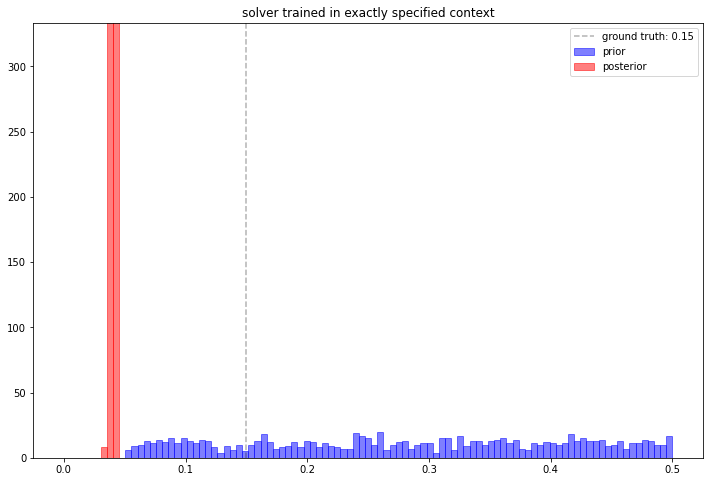

In [310]:
# Plot

fig, ax = plt.subplots()
HIST_BINS = np.linspace(0.0, 0.5, 100)
ax.hist(context_history_exact[0][:, 4], HIST_BINS, lw=1,
        ec="blue", fc="blue", alpha=0.5)
ax.hist(context_history_exact[-1][:, 4], HIST_BINS, lw=1,
        ec="red", fc="red", alpha=0.5)
plt.axvline(x=0.15, alpha=0.3, color='black', linestyle='--')
plt.legend(['ground truth: 0.15', 'prior', 'posterior'])
ax.set_ylim(top=N / 3)
fig.set_size_inches(12, 8)
plt.title('solver trained in exactly specified context')
plt.show()

### b. Misspecified sampled context

In [140]:
# We add the sigma from 0.15 to 0.3 and keep others the same. 
c_mis = {"context_distribution":
        ConstantDistribution(dim=5, constant_vector=np.array([0.98, 0.15, 0.7, 0.7, 0.3]))
    }

ray.shutdown()
ray.init()

solver_mis = ppo.PPOTrainer(env=cMDPWhited, config={
    "env_config": c_mis,
    "framework": "torch",  # config to pass to env class
})

rews = []
for eps in range(35):
    res = solver_mis.train()
    if eps % 5 == 0:
        print(eps, res['episode_reward_mean'])
    rews += [res['episode_reward_mean']]

2022-03-01 22:41:24,199	WARNING util.py:57 -- Install gputil for GPU system monitoring.
2022-03-01 22:41:33,440	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 3343583738892.0x the scale of `vf_clip_param`. This means that it will take more than 3343583738892.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.


0 -33435837388919.6


2022-03-01 22:41:42,748	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 1675931447204.0x the scale of `vf_clip_param`. This means that it will take more than 1675931447204.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-01 22:41:52,004	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 1028243399539.0x the scale of `vf_clip_param`. This means that it will take more than 1028243399539.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-01 22:42:01,207	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 2644547173.0x the scale of `vf_clip_param`. This means that it will take more than 2644547173.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-01 22:42:10,465	WARNING ppo.py:245 -- The magnitude of y

5 -474006924.4682819


2022-03-01 22:42:28,299	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 8459520.0x the scale of `vf_clip_param`. This means that it will take more than 8459520.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-01 22:42:37,014	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 887352.0x the scale of `vf_clip_param`. This means that it will take more than 887352.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-01 22:42:45,676	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 4738.0x the scale of `vf_clip_param`. This means that it will take more than 4738.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-01 22:42:54,390	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 

10 -3210.7791164116165
15 919.3440630284065
20 919.7143043301704
25 1002.9673911404224
30 1044.1567808209945


In [141]:
# Estimation

N = 1000
T = 100

gamma = np.ones((N,)) * 0.98
delta = np.ones((N,)) * 0.15
theta = np.ones((N,)) * 0.7
rho = np.ones((N,)) * 0.7
sigma = np.random.uniform(0.05, 0.5, size=(N,))

context_particles = np.abs(np.vstack((gamma, delta, theta, rho, sigma)).T)
context_distribution = ParticleDistribution(dim=5, particles=context_particles, n_particles=N)

context_history_mis, _ = filter_context(solver_mis,
                                          context_distribution,
                                          gt_obs_arr,
                                          T,
                                          N
                                          )

round 0 posterior mean 0.27490364905020714
round 25 posterior mean 0.08491783217206125
round 50 posterior mean 0.06147568192234131
round 75 posterior mean 0.04929406656125785


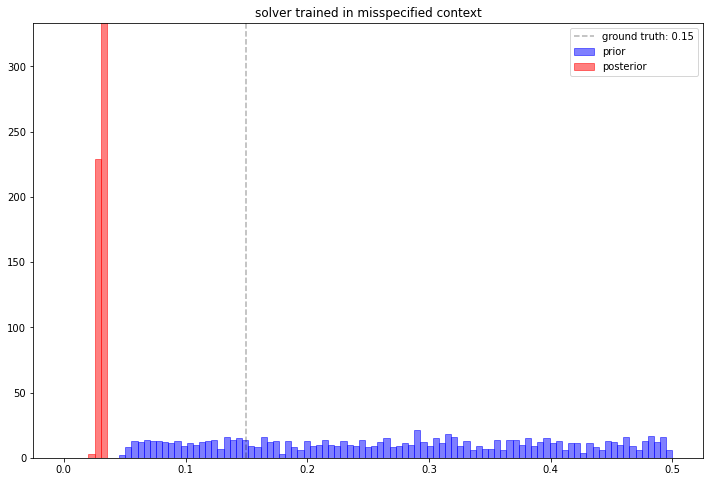

In [142]:
# Plot

fig, ax = plt.subplots()
HIST_BINS = np.linspace(0.0, 0.5, 100)
ax.hist(context_history_exact[0][:, 4], HIST_BINS, lw=1,
        ec="blue", fc="blue", alpha=0.5)
ax.hist(context_history_exact[-1][:, 4], HIST_BINS, lw=1,
        ec="red", fc="red", alpha=0.5)
plt.axvline(x=0.15, alpha=0.3, color='black', linestyle='--')
plt.legend(['ground truth: 0.15', 'prior', 'posterior'])
ax.set_ylim(top=N / 3)
fig.set_size_inches(12, 8)
plt.title('solver trained in misspecified context')
plt.show()

### c. Uniformly sampled context

In [143]:
# Uniformly sample sigma between 0.05 and 0.5
c_uniform = {'context_distribution':
             UniformDistribution(dim=5,
                                 lower_bound_vector=np.array([0.98, 0.15, 0.7, 0.7, 0.05]),
                                 upper_bound_vector=np.array([0.98, 0.15, 0.7, 0.7, 0.5]))}

ray.shutdown()
ray.init()
solver_uniform = ppo.PPOTrainer(env=cMDPWhited, config={
                                                    "env_config": c_uniform,
                                                    "framework": "torch",  # config to pass to env class
                                                })

rews = []
for eps in range(35):
    res = solver_uniform.train()
    if eps % 5 == 0:
        print(eps, res['episode_reward_mean'])
    rews += [res['episode_reward_mean']]

2022-03-01 22:48:11,637	WARNING util.py:57 -- Install gputil for GPU system monitoring.
2022-03-01 22:48:20,887	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 908969038278.0x the scale of `vf_clip_param`. This means that it will take more than 908969038278.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.


0 -9089690382784.74


2022-03-01 22:48:30,381	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 471266725497.0x the scale of `vf_clip_param`. This means that it will take more than 471266725497.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-01 22:48:39,775	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 209991752505.0x the scale of `vf_clip_param`. This means that it will take more than 209991752505.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-01 22:48:49,057	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 10509678127.0x the scale of `vf_clip_param`. This means that it will take more than 10509678127.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-01 22:48:58,229	WARNING ppo.py:245 -- The magnitude of you

5 -1128737973.9830532


2022-03-01 22:49:16,223	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 673758.0x the scale of `vf_clip_param`. This means that it will take more than 673758.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-01 22:49:25,285	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 135890.0x the scale of `vf_clip_param`. This means that it will take more than 135890.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-01 22:49:34,469	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 4878.0x the scale of `vf_clip_param`. This means that it will take more than 4878.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-01 22:49:43,824	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 65

10 -326.40136478347466
15 903.9820144971428
20 1015.5775851929072
25 1096.1838578889328
30 1133.5387834956032


In [144]:
# Estimation

N = 1000
T = 100

gamma = np.ones((N,)) * 0.98
delta = np.ones((N,)) * 0.15
theta = np.ones((N,)) * 0.7
rho = np.ones((N,)) * 0.7
sigma = np.random.uniform(0.05, 0.5, size=(N,))

context_particles = np.abs(np.vstack((gamma, delta, theta, rho, sigma)).T)
context_distribution = ParticleDistribution(dim=5, particles=context_particles, n_particles=N)

context_history_uniform, _ = filter_context(solver_uniform,
                                          context_distribution,
                                          gt_obs_arr,
                                          T,
                                          N
                                          )

round 0 posterior mean 0.27229077869504303
round 25 posterior mean 0.05591523621015297
round 50 posterior mean 0.023894468771364117
round 75 posterior mean 0.02460360930173266


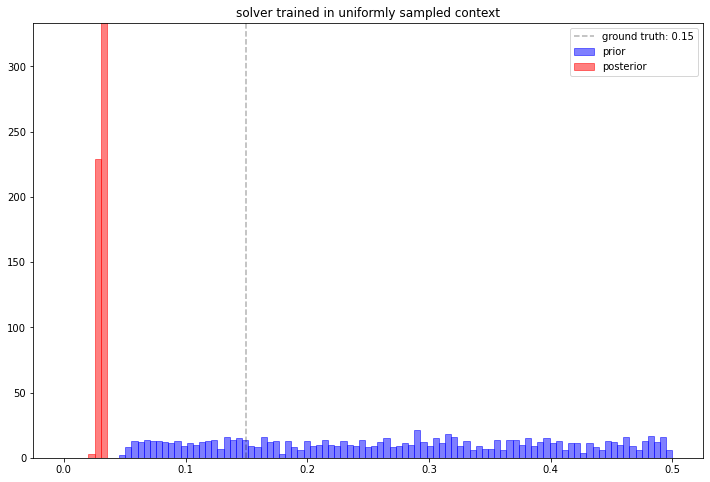

In [145]:
# Plot

fig, ax = plt.subplots()
HIST_BINS = np.linspace(0.0, 0.5, 100)
ax.hist(context_history_exact[0][:, 4], HIST_BINS, lw=1,
        ec="blue", fc="blue", alpha=0.5)
ax.hist(context_history_exact[-1][:, 4], HIST_BINS, lw=1,
        ec="red", fc="red", alpha=0.5)
plt.axvline(x=0.15, alpha=0.3, color='black', linestyle='--')
plt.legend(['ground truth: 0.15', 'prior', 'posterior'])
ax.set_ylim(top=N / 3)
fig.set_size_inches(12, 8)
plt.title('solver trained in uniformly sampled context')
plt.show()

### d. Importance sampling

2022-03-03 20:34:29,732	WARNING util.py:57 -- Install gputil for GPU system monitoring.
2022-03-03 20:34:38,851	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 1999139614588.0x the scale of `vf_clip_param`. This means that it will take more than 1999139614588.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-03 20:34:47,974	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 1050365168985.0x the scale of `vf_clip_param`. This means that it will take more than 1050365168985.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-03 20:34:57,093	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 735631515840.0x the scale of `vf_clip_param`. This means that it will take more than 735631515840.0 iterations for your value function to converge. If this is not intended, consider 

round 0 posterior mean 0.27319177448085596
round 25 posterior mean 0.07513895516242726
round 50 posterior mean 0.05027671642247007
round 75 posterior mean 0.04757140929870149


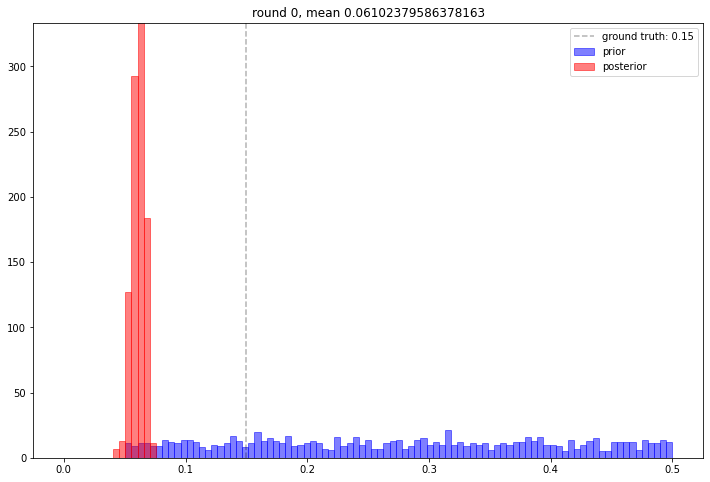

round 0 posterior mean 0.06102379586378163
round 25 posterior mean 0.06914334297554345
round 50 posterior mean 0.08641023049585067
round 75 posterior mean 0.09871915242075195


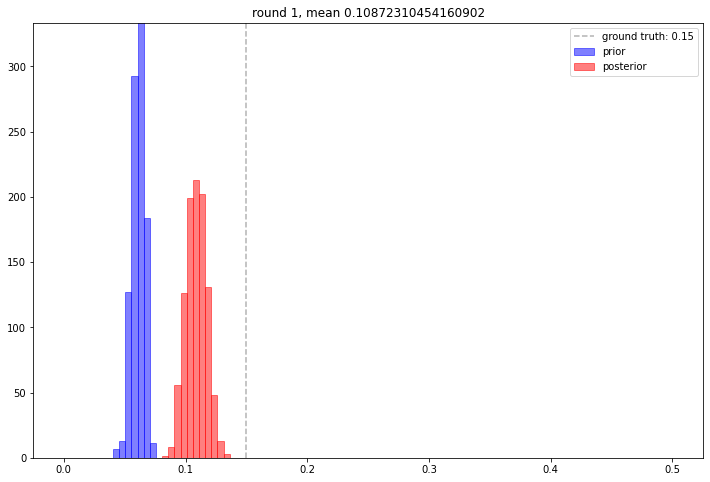

round 0 posterior mean 0.10872310454160902
round 25 posterior mean 0.10746433506313328
round 50 posterior mean 0.12351371866400948
round 75 posterior mean 0.14068245620391845


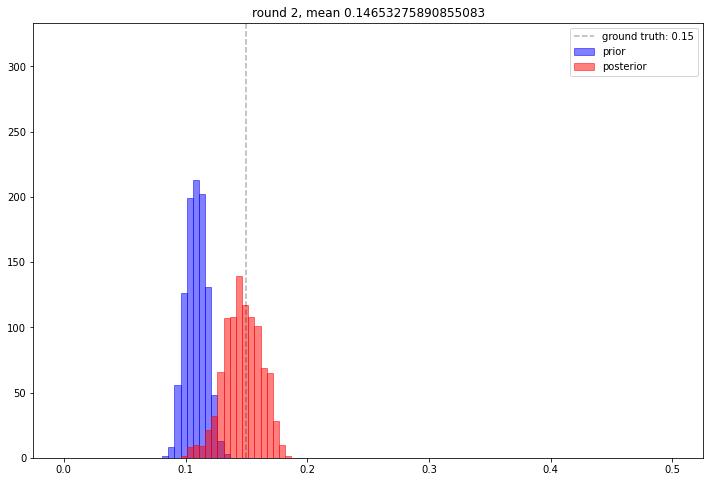

round 0 posterior mean 0.14653275890855083
round 25 posterior mean 0.14479900554177388
round 50 posterior mean 0.15869833795214855
round 75 posterior mean 0.17093143216444162


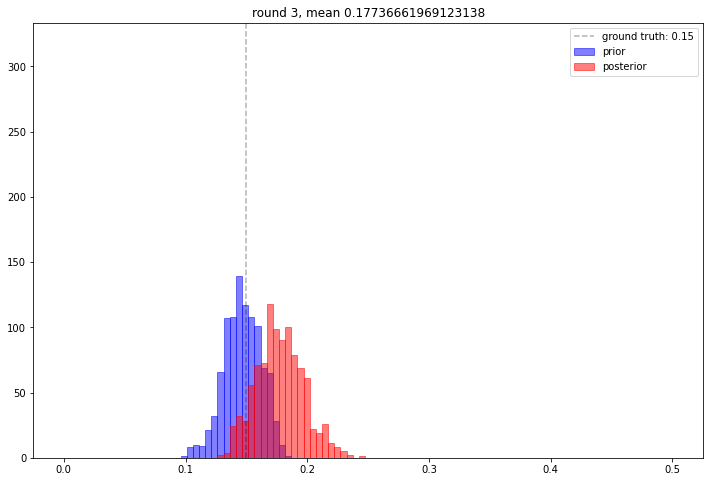

In [304]:
# Initialize prior

N = 1000
T = 100

gamma = np.ones((N,)) * 0.98
delta = np.ones((N,)) * 0.15
theta = np.ones((N,)) * 0.7
rho = np.ones((N,)) * 0.7
sigma = np.random.uniform(0.05, 0.5, size=(N,))

prior_context_particles = np.abs(np.vstack((gamma, delta, theta, rho, sigma)).T)
imp_context_distribution = ParticleDistribution(dim=5, particles=prior_context_particles, n_particles=N)

ray.shutdown()
ray.init()

imp_solver = ppo.PPOTrainer(env=cMDPWhited, config={
                                                "env_config":  {"context_distribution": imp_context_distribution},
                                                "framework": "torch",  # config to pass to env class
                                            })

for update_round in range(4):
    # burn in training
    if update_round == 0:
        for i in range(20):
            imp_solver.train()

    context_history_imp, imp_context_distribution = filter_context(imp_solver,
                                       imp_context_distribution,
                                       gt_obs_arr,
                                       T,
                                       N
                                       )

    fig, ax = plt.subplots()
    HIST_BINS = np.linspace(0.0, 0.5, 100)
    ax.hist(context_history_imp[0][:, 4], HIST_BINS, lw=1,
            ec="blue", fc="blue", alpha=0.5)
    ax.hist(context_history_imp[-1][:, 4], HIST_BINS, lw=1,
            ec="red", fc="red", alpha=0.5)
    plt.axvline(x=0.15, alpha=0.3, color='black', linestyle='--')
    plt.legend(['ground truth: 0.15', 'prior', 'posterior'])
    ax.set_ylim(top=N / 3)
    fig.set_size_inches(12, 8)
    plt.title(f'round {update_round}, mean {context_history_imp[-1][:, 4].mean()}')
    plt.show()

    imp_solver.workers.foreach_worker(
                lambda ev: ev.foreach_env(
                    lambda env: env.set_task(imp_context_distribution)))
    if update_round < 3:
        for _ in range(5):
            imp_solver.train()


---

In [306]:
# use solver
def filter_context(solver_,
                   context_distribution_,
                   gt_obs_arr_,
                   T_,
                   N_
                   ):
    state_arr_ = np.ones((N_,2))
    action_arr_ = np.zeros((N_,))
    context_history_ = []
    for t_ in range(T_):
        # we only use the first 5 steps of the cartpole steps to reduce effect of different episode lengths
        qs_ = np.zeros((N_,))
        for n_ in range(N_):
            context_ = context_distribution_.particles[n_]
            c_local_ = {"context_distribution":
                           ConstantDistribution(dim=5,
                                                constant_vector=context_)
            }
            env_ = cMDPWhited(config=c_local_)
            obs_ = env_.reset()
            if t_ > 0:
                env_.mdp.state = state_arr_[n_]
                obs_ = np.concatenate((np.array(env_.mdp.state), context_), axis=0).flatten()
            action_ = solver_.compute_single_action(obs_)
            obs_, reward_, _, _ = env_.step(action_)
            # estimate likelihood if r >= 1
            action_arr_[n_] = action_
            q = env_.likelihood(gt_obs_arr_[t_], action_arr_[n_], obs_, reward_)
            qs_[n_] = q
            state_arr_[n_] = np.copy(env_.mdp.state)
        if t_ >= 1:
            # truncated importance sampling; [https://arxiv.org/pdf/1905.09800.pdf]
            qs_ = np.clip(qs_, 0, np.percentile(qs_, 90))
            if qs_.sum() == 0:
                continue
            qs_ = qs_ / qs_.sum()
            resample_index_ = context_distribution_.resample_particles_from_probability(p=qs_)
            p_temp_ = context_distribution_.particles
            p_noise_ = np.random.normal(loc=0, scale=p_temp_.std(axis=0), size=p_temp_.shape) * 0.2
            context_distribution_.particles += p_noise_
            context_distribution_.particles = np.clip(context_distribution_.particles, 0.0, 0.5)
            state_arr_ = state_arr_[resample_index_]
            action_arr_ = action_arr_[resample_index_]
        if t_ % 25 == 0:
            print("round", t_, "posterior mean", context_distribution_.particles[:, 4].mean())
        context_history_ += [context_distribution_.particles.copy()]
    return context_history_, context_distribution_

2022-03-03 16:42:26,633	WARNING util.py:57 -- Install gputil for GPU system monitoring.
2022-03-03 16:42:35,686	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 600496517797.0x the scale of `vf_clip_param`. This means that it will take more than 600496517797.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-03 16:42:44,779	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 307923381381.0x the scale of `vf_clip_param`. This means that it will take more than 307923381381.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-03-03 16:42:53,808	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 50088922391.0x the scale of `vf_clip_param`. This means that it will take more than 50088922391.0 iterations for your value function to converge. If this is not intended, consider increa

round 0 posterior mean 0.25040302575185003


C:\Users\ZhenghaoJiang\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1835: RuntimeWarning: divide by zero encountered in double_scalars
  x = np.asarray((x - loc)/scale, dtype=dtyp)


round 25 posterior mean 0.06965443661224233
round 50 posterior mean 0.05703952273626881
round 75 posterior mean 0.05807960912084826


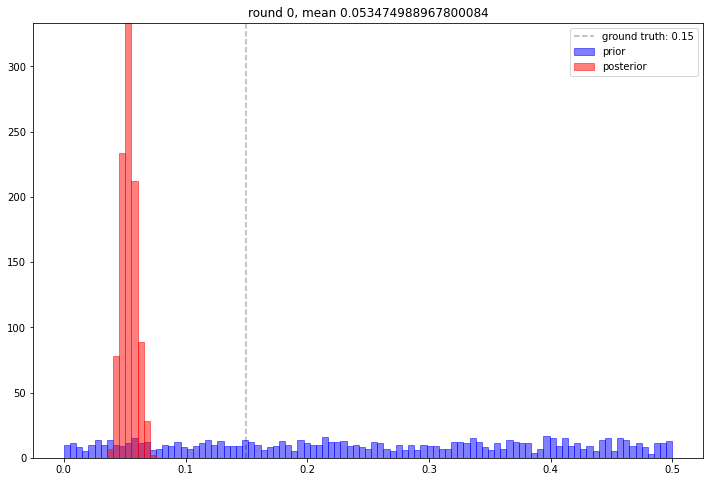

round 0 posterior mean 0.053474988967800084
round 25 posterior mean 0.053958579075129035
round 50 posterior mean 0.061736352929610355
round 75 posterior mean 0.07563825365422701


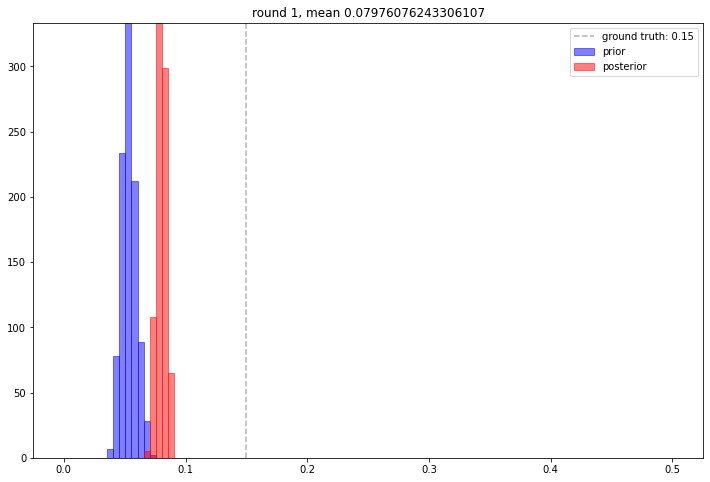

round 0 posterior mean 0.07976076243306107
round 25 posterior mean 0.07926274071346566
round 50 posterior mean 0.08850186877737444
round 75 posterior mean 0.0915940472063811


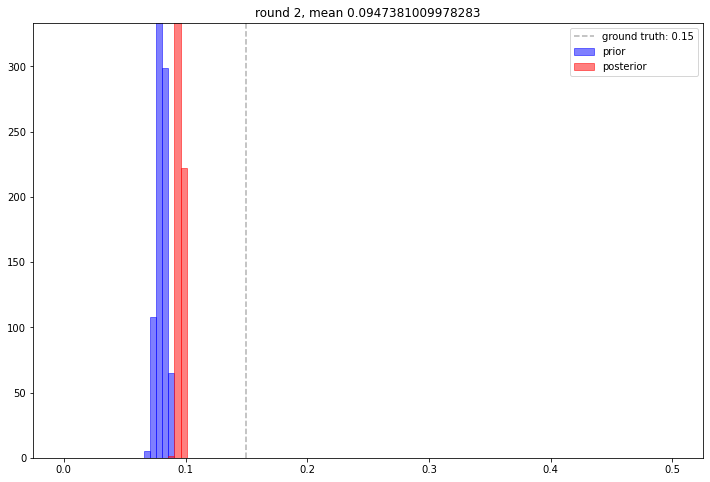

In [295]:
# Initialize prior

N = 1000
T = 100

gamma = np.ones((N,)) * 0.98
delta = np.ones((N,)) * 0.15
theta = np.ones((N,)) * 0.7
# theta = np.random.uniform(0.6, 1.0, size=(N,))
rho = np.ones((N,)) * 0.7
# rho = np.random.uniform(0.6, 1.0, size=(N,))
# sigma = np.ones((N,)) * 0.15
sigma = np.random.uniform(0.0, 0.5, size=(N,))

prior_context_particles = np.abs(np.vstack((gamma, delta, theta, rho, sigma)).T)
imp_context_distribution = ParticleDistribution(dim=5, particles=prior_context_particles, n_particles=N)

ray.shutdown()
ray.init()

imp_solver = ppo.PPOTrainer(env=cMDPWhited, config={
                                                "env_config":  {"context_distribution": imp_context_distribution},
                                                "framework": "torch",  # config to pass to env class
                                            })

for update_round in range(3):
    # burn in training
    if update_round == 0:
        for i in range(20):
            imp_solver.train()

    context_history_imp, imp_context_distribution = filter_context(imp_solver,
                                       imp_context_distribution,
                                       gt_obs_arr,
                                       T,
                                       N
                                       )

    fig, ax = plt.subplots()
    HIST_BINS = np.linspace(0.0, 0.5, 100)
    ax.hist(context_history_imp[0][:, 4], HIST_BINS, lw=1,
            ec="blue", fc="blue", alpha=0.5)
    ax.hist(context_history_imp[-1][:, 4], HIST_BINS, lw=1,
            ec="red", fc="red", alpha=0.5)
    plt.axvline(x=0.15, alpha=0.3, color='black', linestyle='--')
    plt.legend(['ground truth: 0.15', 'prior', 'posterior'])
    ax.set_ylim(top=N / 3)
    fig.set_size_inches(12, 8)
    plt.title(f'round {update_round}, mean {context_history_imp[-1][:, 4].mean()}')
    plt.show()

    imp_solver.workers.foreach_worker(
                lambda ev: ev.foreach_env(
                    lambda env: env.set_task(imp_context_distribution)))
    for _ in range(5):
        imp_solver.train()
